In [1]:
# database and persisting
import sqlite3
import pickle

# date
import datetime

# vocab
from nltk.corpus import stopwords
from collections import Counter
from collections import defaultdict as dd

# review runtime
from tqdm import tqdm

# python packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, date

# data processesing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# ARIMA
from pyramid.arima import auto_arima

# lstm
from keras.models import Sequential, Model, model_from_json
from keras.layers import LSTM, Dense, Dropout, Flatten, GRU, CuDNNLSTM
from keras.optimizers import SGD
import tensorflow as tf

# # GPU only
# from keras import backend as K
# cfg = K.tf.ConfigProto()
# cfg.gpu_options.allow_growth = True
# K.set_session(K.tf.Session(config=cfg))

c:\users\kenny\anaconda3\envs\109b\lib\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)
Using TensorFlow backend.


In [2]:
# read in functions from python scripts
exec(open('python_scripts/model_functions.py').read())
exec(open('python_scripts/tokenization_functions.py').read())
exec(open('python_scripts/save_load_functions.py').read())

# Set seed for repeatable results
np.random.seed(1103)
tf.set_random_seed(1103)

# database connection
conn = sqlite3.connect('stocks_data/sp500_light.db')
c = conn.cursor()

# parameters
startdate = '2010-06-29'
enddate = '2018-12-31'

# stock dictionary
ticker2name = {'AAPL': 'apple', 'AMZN': 'amazon', 'DIS': 'disney', 'GS': 'goldman_sachs', 'TSLA': 'tesla'}

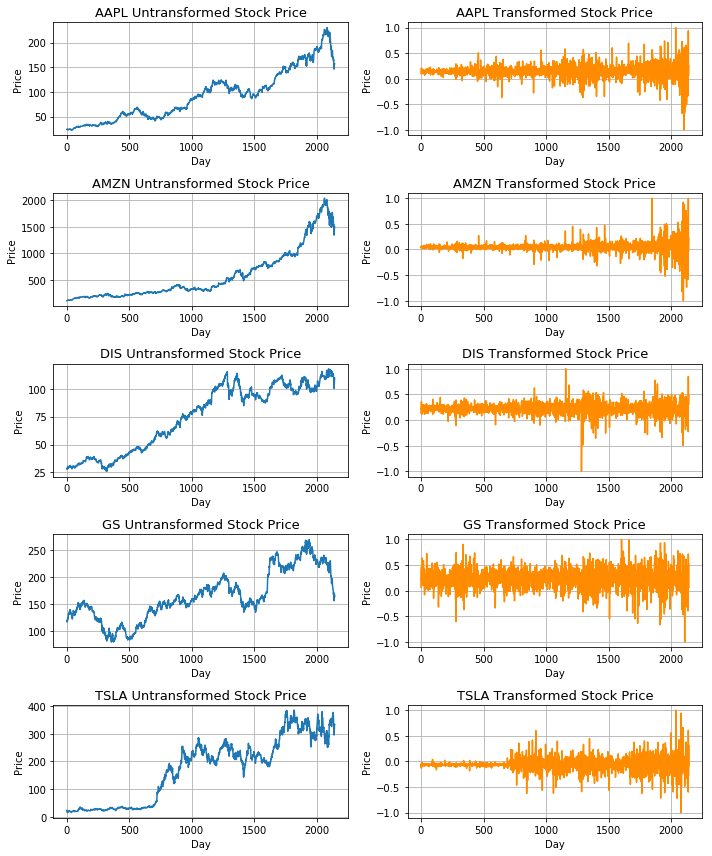

In [26]:
### GET SIMPLE PLOTS FOR STOCK PRICES ###

# plot shape
f, axarr = plt.subplots(len(ticker2name), 2, figsize=(10,12))

# iterate over each stock
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]
    
    # get stock data
    if sym == 'TSLA':
        hdata = pd.read_csv('stocks_data/' + name + '.csv')
    else:
        hdata = pd.read_sql("SELECT * FROM fact_table WHERE symbol='{}' AND date BETWEEN '{}' AND '{}'".format(sym, startdate, enddate), con=conn)
    # get time series
    ys = hdata['adj_close']
    hdata.drop(labels=['symbol'], axis=1, inplace=True)
    
    # modify for dictionary use
    hdata.columns = ['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ_CLOSE', 'VOLUME']

    # untransformed 
    fs = 10
    axarr[i,0].plot(np.array(ys), label=' untransformed price')
    axarr[i,0].set_title('{} Untransformed Stock Price'.format(sym), fontsize=fs*1.3)
    axarr[i,0].set_xlabel('Day', fontsize=fs)
    axarr[i,0].set_ylabel('Price', fontsize=fs)
    axarr[i,0].grid()
    
    # transformed
    scaler = MinMaxScaler(feature_range=(-1, 1))
    first_order_diffs = np.array(ys)[1:]-np.array(ys)[:-1]
    axarr[i,1].plot(scaler.fit_transform(first_order_diffs.reshape(-1,1)), 'darkorange', label='first order differenced and scaled price')
    axarr[i,1].set_title('{} Transformed Stock Price'.format(sym), fontsize=fs*1.3)
    axarr[i,1].set_xlabel('Day', fontsize=fs)
    axarr[i,1].set_ylabel('Price', fontsize=fs)
    axarr[i,1].grid()
    
# format and save
plt.tight_layout()
plt.savefig('plots/simple_prices.png', bbox_inches='tight')

In [3]:
# fixed hyperparameters
n_lag = 60
n_batch = 1
prop_test = .3
n_epochs = 50
fs = 10

In [38]:
# train models
for n_seq in [5, 20, 60]: 
    for i in range(len(ticker2name)):
        sym = list(ticker2name.keys())[i]
        name = ticker2name[sym]
        
        # generate inputs
        series, scaler, train, test, n_test = generate_inputs(sym, name) # arima and lstm
        series, n_test, scaler_mult, train_mult, test_mult = generate_inputs_mv(sym, name, gramtype) # lstm news
        
        ############
        ## ARIMA ###
        ############

        model_name = 'arima'
        n_neurons = 0

        # fit model and make forecasts, save forecasts
        forecasts = arima_fit_and_forecast(test, n_lag, n_seq)
        store_arima_forecasts(forecasts, model_name, name, n_epochs, n_neurons, n_lag, n_seq)
        
        # inverse transform forecasts and test
        forecasts = inverse_transform(series, forecasts, scaler, n_test)
        actual = [row[n_lag:] for row in test]
        actual = inverse_transform(series, actual, scaler, n_test)

        # evaluate forecasts and save test loss
        test_loss = evaluate_forecasts(actual, forecasts, n_lag, n_seq)
        store_test_rmses(test_loss, model_name, name, n_epochs, n_neurons, n_lag, n_seq)

        # plot forecasts
        plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)
        
        for n_neurons in [10, 50, 100]:

            ############
            ### LSTM ###
            ############
            model_name = 'lstm'
            print(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            try:
                model = load_keras_model(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            except:
                # fit model and save model and train loss
                model, train_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
                store_keras_model(model, model_name, name, n_epochs, n_neurons, n_lag, n_seq)
                store_train_rmses(train_loss, model_name, name, n_epochs, n_neurons, n_lag, n_seq)

                # make forecasts
                forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

                # inverse transform forecasts and test
                forecasts = inverse_transform(series, forecasts, scaler, n_test)
                actual = [row[n_lag:] for row in test]
                actual = inverse_transform(series, actual, scaler, n_test)

                # evaluate forecasts and save test loss
                test_loss = evaluate_forecasts(actual, forecasts, n_lag, n_seq)
                store_test_rmses(test_loss, model_name, name, n_epochs, n_neurons, n_lag, n_seq)

                # plot train loss and forecasts
                plot_train_loss(train_loss, sym, n_neurons, n_seq, fs)
                plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)
            
            #################
            ### LSTM News ###
            #################
            model_name = 'news'
            print(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            try:
                model = load_keras_model(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            except:                
                # fit model and save model and train loss
                model, train_loss = fit_lstm_mv(train_mult, n_lag, n_seq, n_batch, n_epochs, n_neurons)
                store_keras_model(model, model_name, name, n_epochs, n_neurons, n_lag, n_seq)
                store_train_rmses(train_loss, model_name, name, n_epochs, n_neurons, n_lag, n_seq)

                # make forecasts
                forecasts = make_forecasts_mv(model, n_batch, train_mult, test_mult, n_lag, n_seq)

                # inverse transform forecasts and test
                forecasts = inverse_transform(series, forecasts, scaler_mult, n_test)
                actual = [row[n_lag:] for row in test_mult[:,-1,:]]
                actual = inverse_transform(series, actual, scaler_mult, n_test)

                # evaluate forecasts and save test loss
                test_loss = evaluate_forecasts(actual, forecasts, n_lag, n_seq)
                store_test_rmses(test_loss, model_name, name, n_epochs, n_neurons, n_lag, n_seq)

                # plot train loss and forecasts
                plot_train_loss(train_loss, sym, n_neurons, n_seq, fs)
                plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)



  0%|                                                                                          | 0/623 [00:00<?, ?it/s]

  0%|▏                                                                                 | 1/623 [00:00<03:35,  2.89it/s]

  0%|▎                                                                                 | 2/623 [00:00<03:26,  3.01it/s]

  0%|▍                                                                                 | 3/623 [00:01<03:31,  2.93it/s]

  1%|▌                                                                                 | 4/623 [00:01<03:11,  3.24it/s]

  1%|▋                                                                                 | 5/623 [00:01<03:15,  3.15it/s]

  1%|▊                                                                                 | 6/623 [00:01<03:21,  3.06it/s]

  1%|▉                                                                                 | 7/623 [00:02<03:16,  3.13it/s]

  1%|█                        

 22%|█████████████████▎                                                              | 135/623 [00:32<01:58,  4.11it/s]

 22%|█████████████████▍                                                              | 136/623 [00:32<01:53,  4.30it/s]

 22%|█████████████████▌                                                              | 137/623 [00:32<01:47,  4.54it/s]

 22%|█████████████████▋                                                              | 138/623 [00:32<01:37,  4.98it/s]

 22%|█████████████████▊                                                              | 139/623 [00:32<01:38,  4.90it/s]

 22%|█████████████████▉                                                              | 140/623 [00:33<01:45,  4.57it/s]

 23%|██████████████████                                                              | 141/623 [00:33<01:54,  4.23it/s]

 23%|██████████████████▏                                                             | 142/623 [00:33<01:47,  4.49it/s]

 23%|██████████████████▎        

 44%|███████████████████████████████████▏                                            | 274/623 [00:59<00:48,  7.15it/s]

 44%|███████████████████████████████████▎                                            | 275/623 [00:59<00:53,  6.56it/s]

 44%|███████████████████████████████████▍                                            | 276/623 [00:59<00:49,  7.03it/s]

 45%|███████████████████████████████████▋                                            | 278/623 [00:59<00:47,  7.29it/s]

 45%|███████████████████████████████████▊                                            | 279/623 [00:59<00:54,  6.32it/s]

 45%|███████████████████████████████████▉                                            | 280/623 [00:59<00:54,  6.30it/s]

 45%|████████████████████████████████████                                            | 281/623 [01:00<00:54,  6.31it/s]

 45%|████████████████████████████████████▏                                           | 282/623 [01:00<00:55,  6.17it/s]

 45%|███████████████████████████

 66%|████████████████████████████████████████████████████▉                           | 412/623 [01:42<02:47,  1.26it/s]

 66%|█████████████████████████████████████████████████████                           | 413/623 [01:43<02:20,  1.50it/s]

 66%|█████████████████████████████████████████████████████▏                          | 414/623 [01:43<02:01,  1.71it/s]

 67%|█████████████████████████████████████████████████████▎                          | 415/623 [01:43<01:47,  1.93it/s]

 67%|█████████████████████████████████████████████████████▍                          | 416/623 [01:44<01:35,  2.16it/s]

 67%|█████████████████████████████████████████████████████▌                          | 417/623 [01:44<01:26,  2.39it/s]

KeyboardInterrupt: 

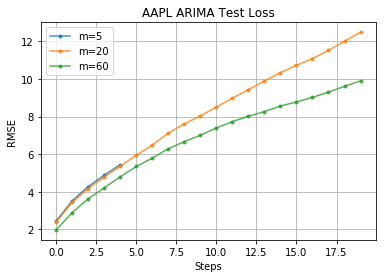

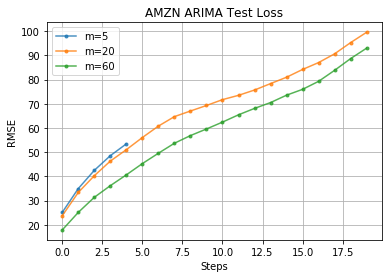

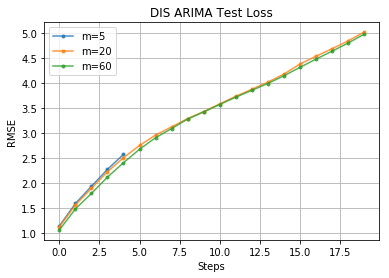

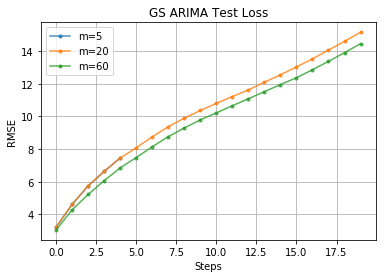

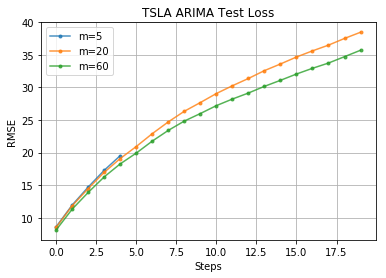

In [31]:
# plot test losses for arima
model_name = 'arima'
n_neurons = 0
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]
    plt.figure()
    plt.title('{} ARIMA Test Loss'.format(sym))
    plt.xlabel('Steps')
    plt.ylabel('RMSE')
    for n_seq in [5, 20, 60]:
        loaded_rmses = load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
        plt.plot(loaded_rmses[:20], '.-', label='m='+str(n_seq), alpha=.8)
    plt.legend()
    plt.grid()
    plt.xticks()
    plt.savefig('plots/testloss_arima_{}.png'.format(name), bbox_inches='tight')    

<Figure size 432x288 with 0 Axes>

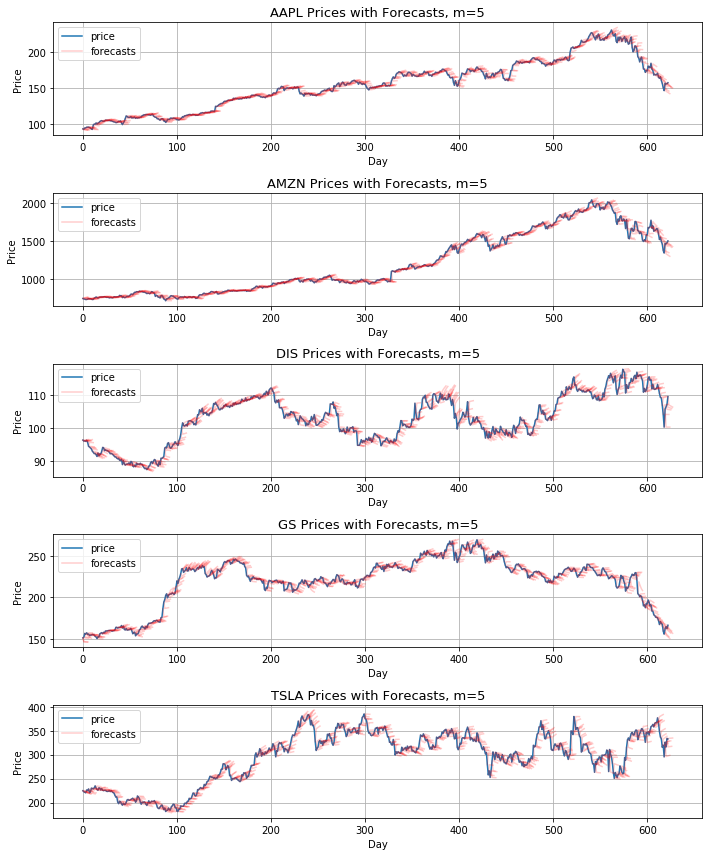

<Figure size 432x288 with 0 Axes>

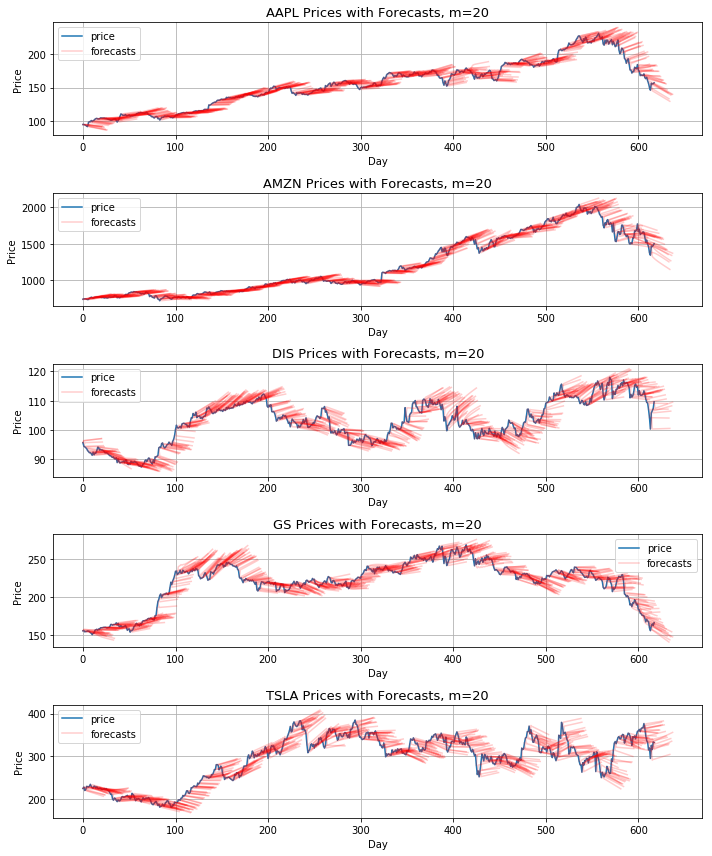

<Figure size 432x288 with 0 Axes>

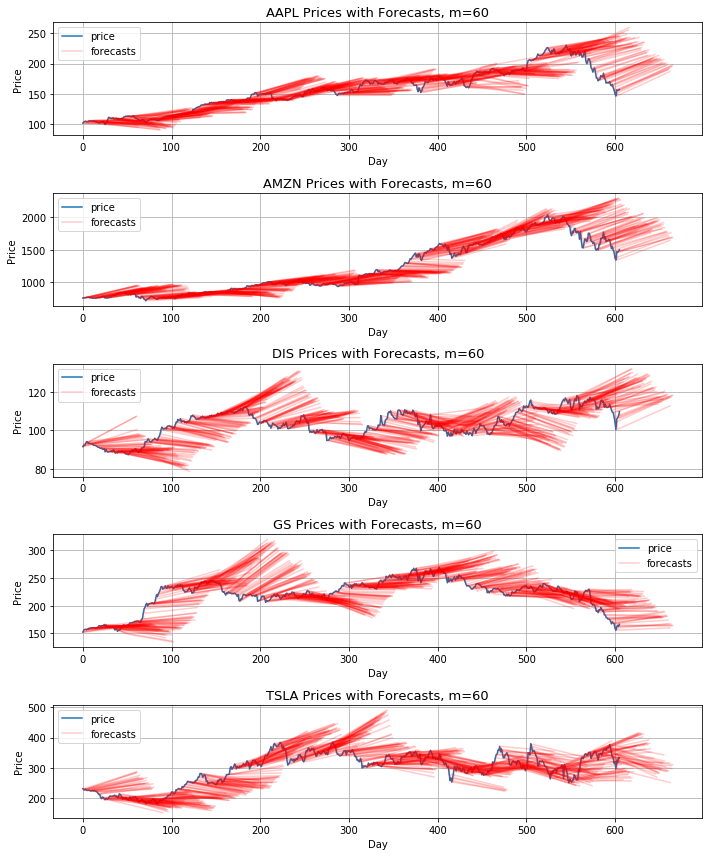

In [19]:
# arima forecast plots
model_name = 'arima'
n_neurons = 0
for n_seq in [5, 20, 60]:
    plt.figure()
    f, axarr = plt.subplots(5, 1, figsize=(10,12))
    for i in range(len(ticker2name)):
        sym = list(ticker2name.keys())[i]
        name = ticker2name[sym]

        # generate inputs
        series, scaler, train, test, n_test = generate_inputs(sym, name)
        
        # load forecasts
        forecasts = load_arima_forecasts(model_name, name, n_epochs, n_neurons, n_lag, n_seq)

        # inverse transform forecasts and test
        forecasts = inverse_transform(series, forecasts, scaler, n_test)
        actual = [row[n_lag:] for row in test]
        actual = inverse_transform(series, actual, scaler, n_test)

        # plot forecasts and save
        plot_arima_forecasts_grid(series, forecasts, n_seq, n_test, axarr, i, fs)
    plt.tight_layout()
    plt.savefig('plots/fplots_arima_{}.png'.format(n_seq), bbox_inches='tight')    

<Figure size 432x288 with 0 Axes>

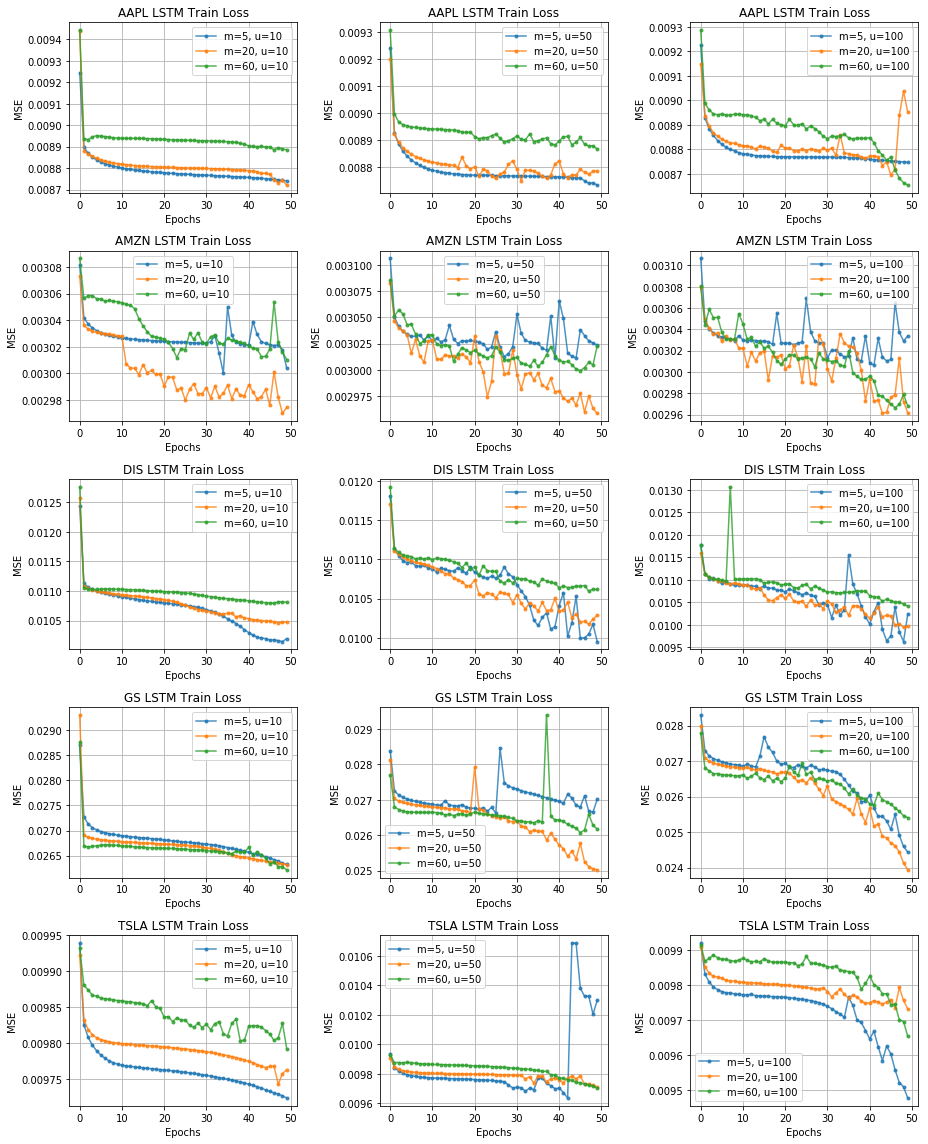

In [45]:
# plot train losses for LSTMs
model_name = 'lstm'
# model_name = 'news'
n_seqs = [5, 20, 60]
n_neuronss = [10, 50, 100]
plt.figure()
f, axarr = plt.subplots(5, 3, figsize=(13,16))
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]
    for j in range(len(n_neuronss)):
        n_neurons = n_neuronss[j]
        for k in range(len(n_seqs)):
            n_seq = n_seqs[k]
            loaded_rmses = load_train_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            axarr[i,j].set_title('{} LSTM Train Loss'.format(sym))#, fontsize=16)
#             axarr[i,j].set_title('{} LSTM w/News Train Loss'.format(sym))#, fontsize=16)
            axarr[i,j].set_xlabel('Epochs')#, fontsize=13)
            axarr[i,j].set_ylabel('MSE')#, fontsize=13)
            axarr[i,j].plot(loaded_rmses, '.-', label='m={}, u={}'.format(n_seq, n_neurons), alpha=.8)
        axarr[i,j].legend()
        axarr[i,j].grid()
plt.tight_layout()
plt.savefig('plots/trainloss_{}.png'.format(model_name), bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

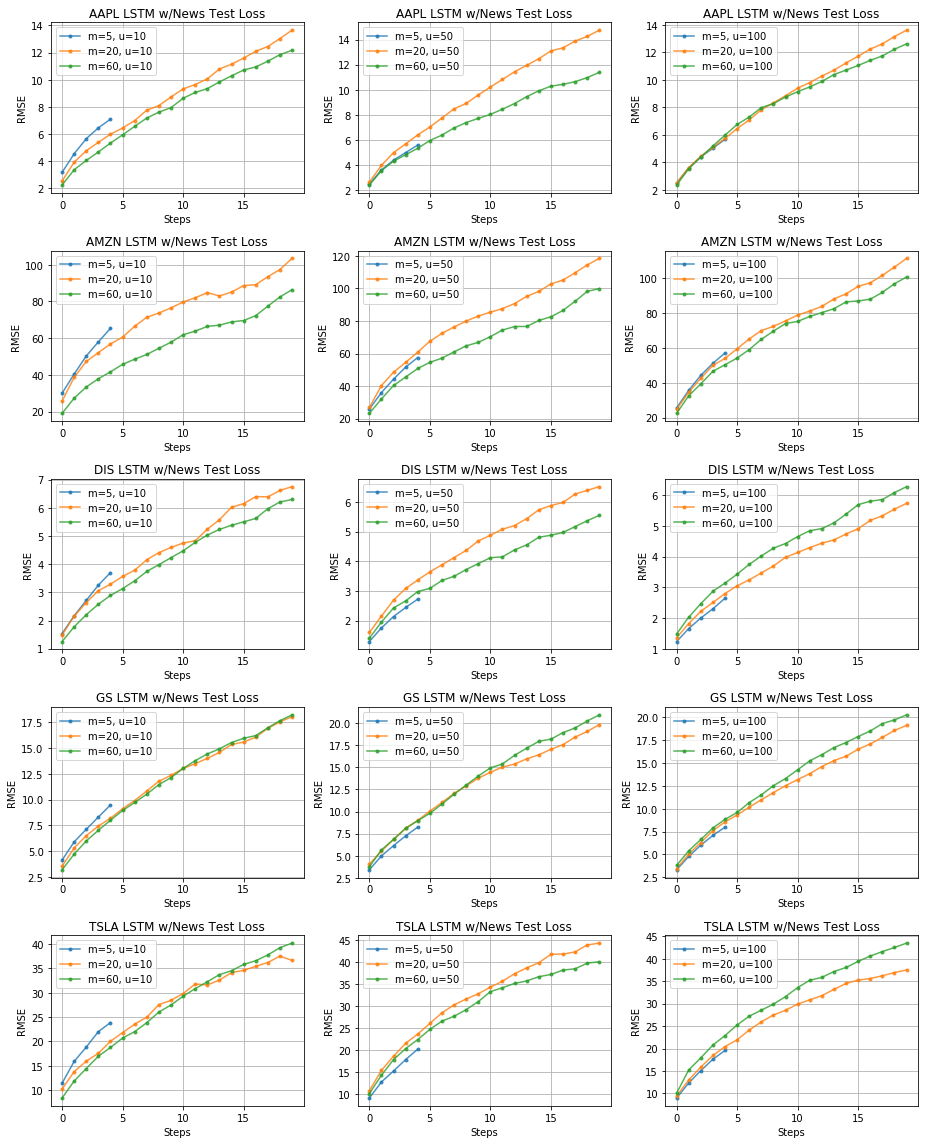

In [40]:
# plot test losses for LSTMs
# model_name = 'lstm'
model_name = 'news'
n_seqs = [5, 20, 60]
n_neuronss = [10, 50, 100]
plt.figure()
f, axarr = plt.subplots(5, 3, figsize=(13,16))
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]

#     # by steps 
#     savestring = 'bysteps'
#     for j in range(len(n_seqs)):
#         n_seq = n_seqs[j]
#         for k in range(len(n_neuronss)):
#             n_neurons = n_neuronss[k]
    # by neurons
    savestring = 'byneurons'
    for j in range(len(n_neuronss)):
        n_neurons = n_neuronss[j]
        for k in range(len(n_seqs)):
            n_seq = n_seqs[k]
            
            # plot
            loaded_rmses = load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
#             axarr[i,j].set_title('{} LSTM Test Loss'.format(sym))#, fontsize=16)
            axarr[i,j].set_title('{} LSTM w/News Test Loss'.format(sym))#, fontsize=16)
            axarr[i,j].set_xlabel('Steps')#, fontsize=13)
            axarr[i,j].set_ylabel('RMSE')#, fontsize=13)
            axarr[i,j].plot(loaded_rmses[:20], '.-', label='m={}, u={}'.format(n_seq, n_neurons), alpha=.8)
        axarr[i,j].legend()
        axarr[i,j].grid()
plt.tight_layout()
plt.savefig('plots/testloss_{}_{}.png'.format(model_name, savestring), bbox_inches='tight')    

<Figure size 432x288 with 0 Axes>

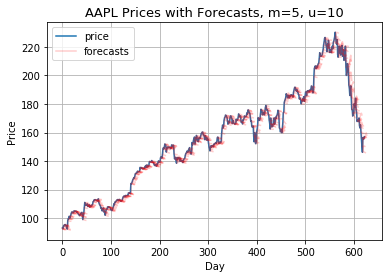

<Figure size 432x288 with 0 Axes>

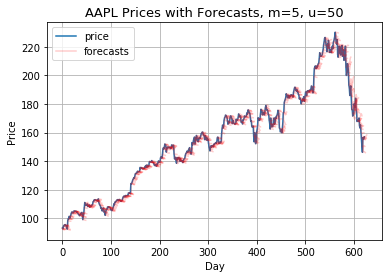

<Figure size 432x288 with 0 Axes>

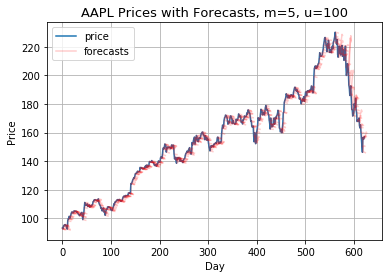

<Figure size 432x288 with 0 Axes>

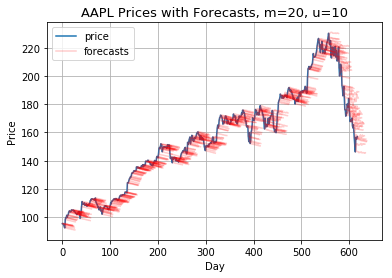

<Figure size 432x288 with 0 Axes>

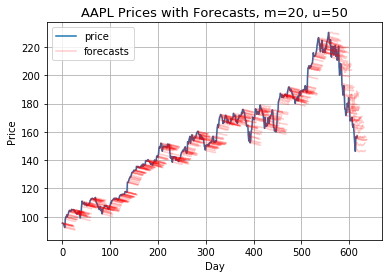

<Figure size 432x288 with 0 Axes>

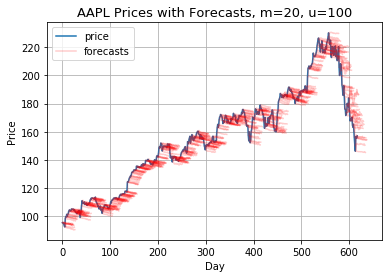

<Figure size 432x288 with 0 Axes>

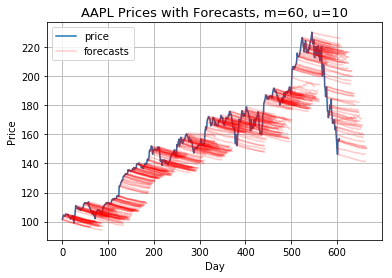

<Figure size 432x288 with 0 Axes>

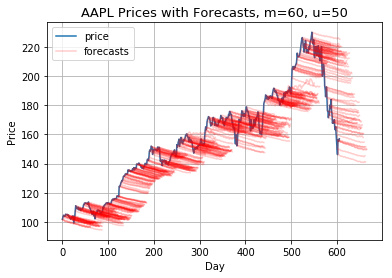

<Figure size 432x288 with 0 Axes>

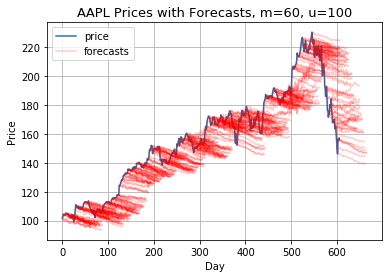

<Figure size 432x288 with 0 Axes>

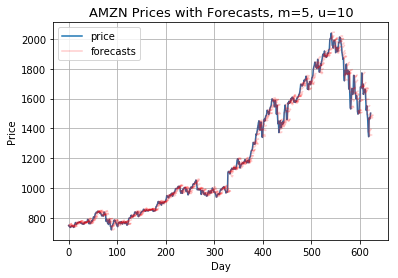

<Figure size 432x288 with 0 Axes>

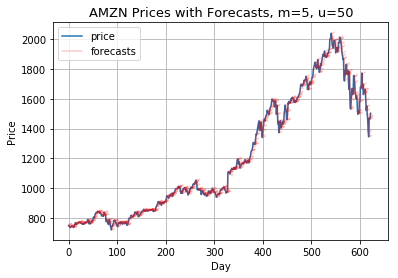

<Figure size 432x288 with 0 Axes>

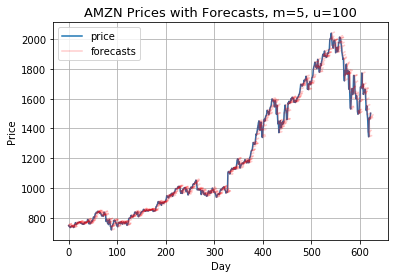

<Figure size 432x288 with 0 Axes>

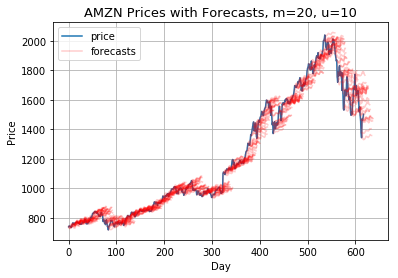

<Figure size 432x288 with 0 Axes>

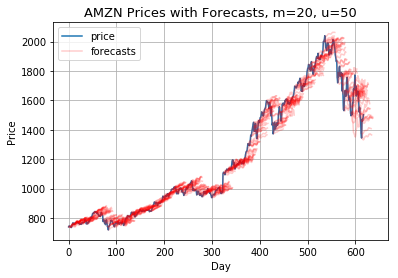

<Figure size 432x288 with 0 Axes>

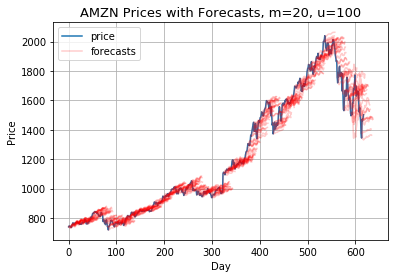

<Figure size 432x288 with 0 Axes>

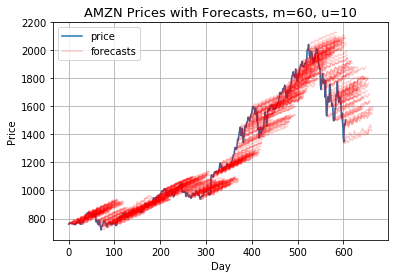

<Figure size 432x288 with 0 Axes>

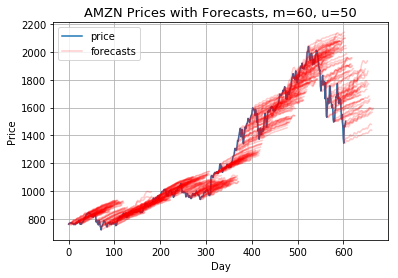

<Figure size 432x288 with 0 Axes>

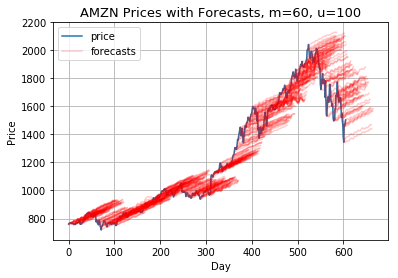

<Figure size 432x288 with 0 Axes>

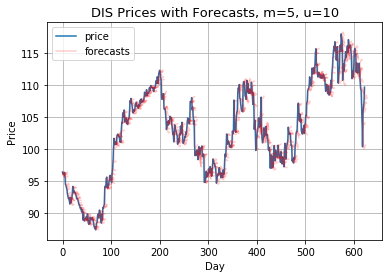

<Figure size 432x288 with 0 Axes>

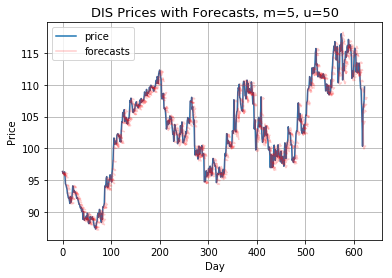

<Figure size 432x288 with 0 Axes>

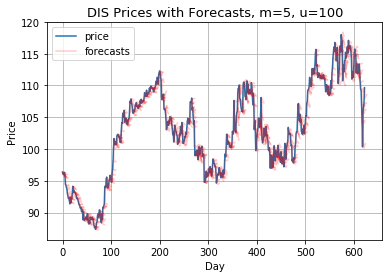

<Figure size 432x288 with 0 Axes>

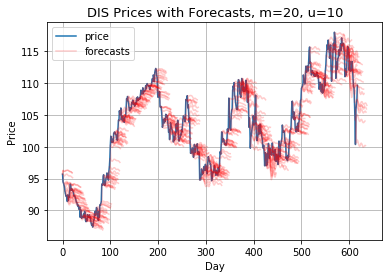

<Figure size 432x288 with 0 Axes>

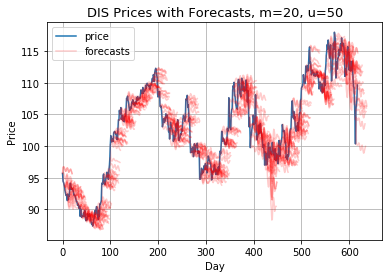

<Figure size 432x288 with 0 Axes>

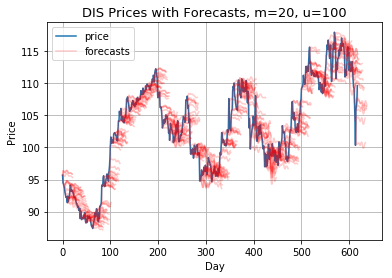

<Figure size 432x288 with 0 Axes>

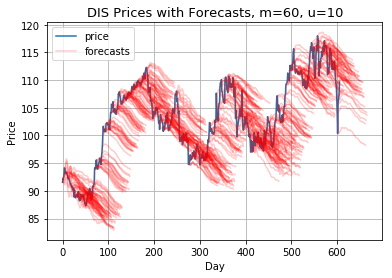

<Figure size 432x288 with 0 Axes>

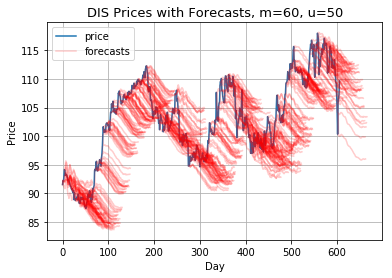

<Figure size 432x288 with 0 Axes>

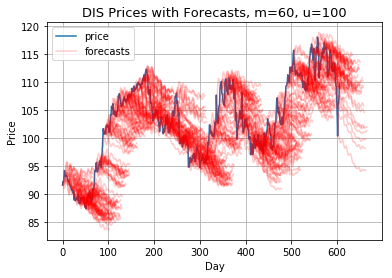

<Figure size 432x288 with 0 Axes>

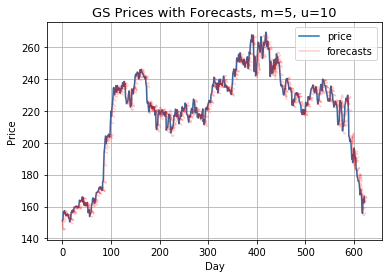

<Figure size 432x288 with 0 Axes>

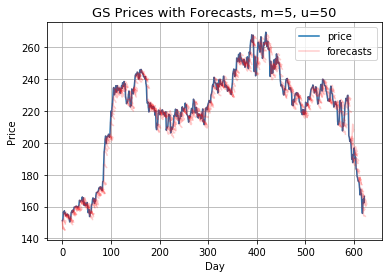

<Figure size 432x288 with 0 Axes>

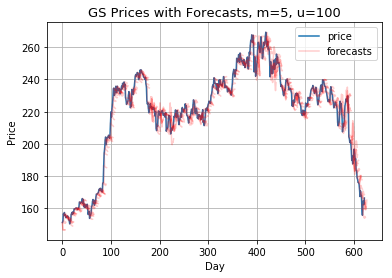

<Figure size 432x288 with 0 Axes>

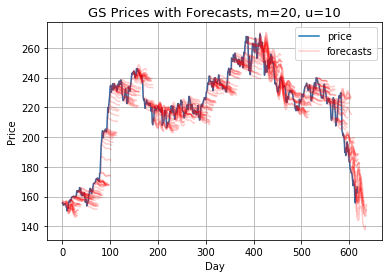

<Figure size 432x288 with 0 Axes>

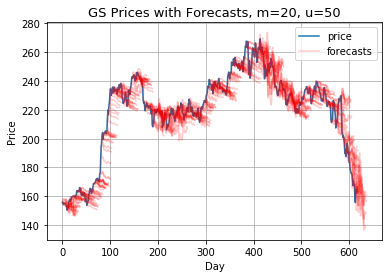

<Figure size 432x288 with 0 Axes>

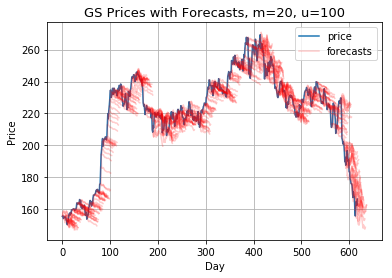

<Figure size 432x288 with 0 Axes>

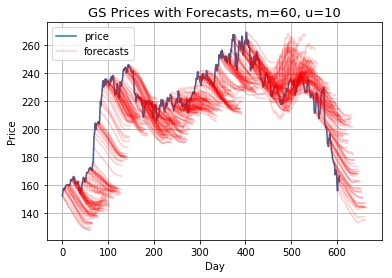

<Figure size 432x288 with 0 Axes>

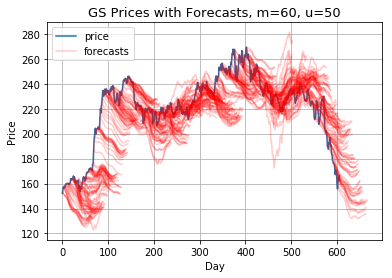

<Figure size 432x288 with 0 Axes>

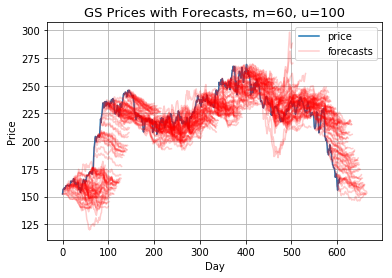

<Figure size 432x288 with 0 Axes>

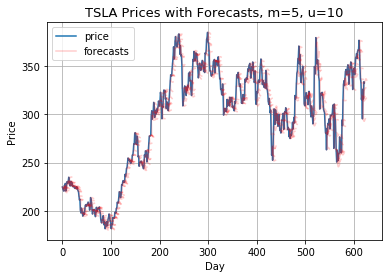

<Figure size 432x288 with 0 Axes>

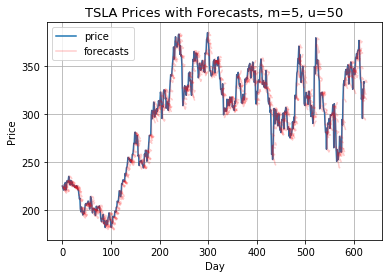

<Figure size 432x288 with 0 Axes>

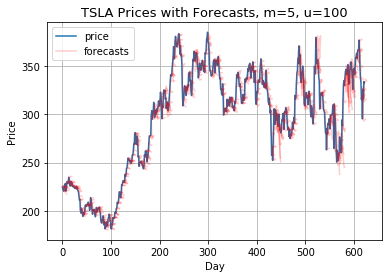

<Figure size 432x288 with 0 Axes>

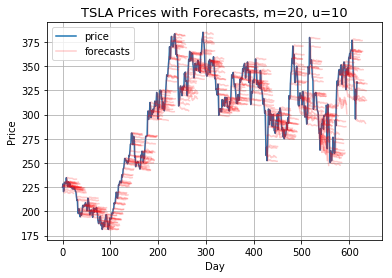

<Figure size 432x288 with 0 Axes>

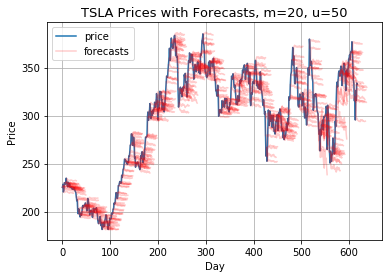

<Figure size 432x288 with 0 Axes>

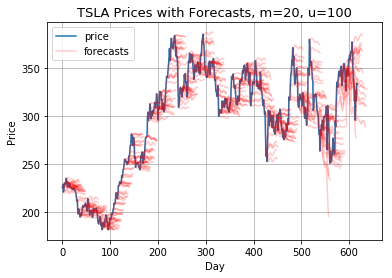

<Figure size 432x288 with 0 Axes>

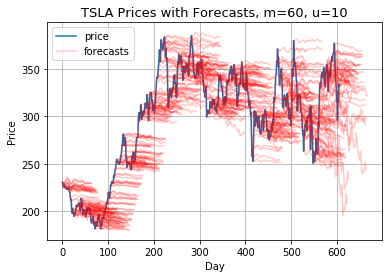

<Figure size 432x288 with 0 Axes>

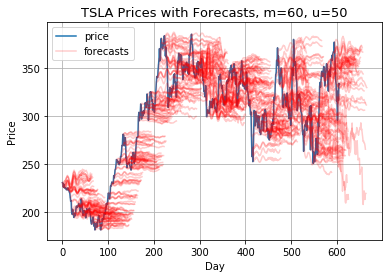

<Figure size 432x288 with 0 Axes>

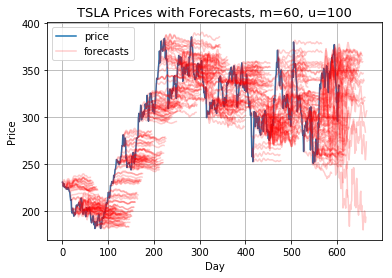

In [36]:
# lstm forecast plots
n_neuronss = [10, 50, 100]
model_name = 'lstm'
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]
    for n_seq in [5, 20, 60]: 

        # generate inputs
        series, scaler, train, test, n_test = generate_inputs(sym, name)

        for j in range(len(n_neuronss)):
            n_neurons = n_neuronss[j]
            
            # load model and loss
            model = load_keras_model(model_name, name, n_epochs, n_neurons, n_lag, n_seq)

            # make forecasts
            forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

            # inverse transform forecasts and test
            forecasts = inverse_transform(series, forecasts, scaler, n_test)
            actual = [row[n_lag:] for row in test]
            actual = inverse_transform(series, actual, scaler, n_test)
        
            # plot forecasts and save
            plt.figure()
            plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)
            plt.savefig('plots/fplots_{}_{}_{}_{}.png'.format(model_name, name, n_seq, n_neurons))  
            plt.show()




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 6/2142 [00:00<00:39, 54.13it/s]


  1%|          | 12/2142 [00:00<00:39, 54.54it/s]


  1%|          | 18/2142 [00:00<00:38, 54.88it/s]


  1%|          | 24/2142 [00:00<00:39, 54.10it/s]


  1%|▏         | 30/2142 [00:00<00:39, 53.95it/s]


  2%|▏         | 36/2142 [00:00<00:39, 53.71it/s]


  2%|▏         | 42/2142 [00:00<00:38, 54.15it/s]


  2%|▏         | 48/2142 [00:00<00:38, 53.89it/s]


  3%|▎         | 54/2142 [00:00<00:38, 53.88it/s]


  3%|▎         | 60/2142 [00:01<00:38, 54.38it/s]


  3%|▎         | 66/2142 [00:01<00:37, 54.67it/s]


  3%|▎         | 72/2142 [00:01<00:37, 55.17it/s]


  4%|▎         | 78/2142 [00:01<00:37, 54.87it/s]


  4%|▍         | 84/2142 [00:01<00:37, 54.80it/s]


  4%|▍         | 90/2142 [00:01<00:37, 55.31it/s]


  4%|▍         | 96/2142 [00:01<00:36, 55.52it/s]


  5%|▍         | 102/2142 [00:01<00:36, 55.67it/s]


  5%|▌         | 108/2142 [00:01<00:36, 55.34it/s]


  5%|▌         | 

<Figure size 432x288 with 0 Axes>

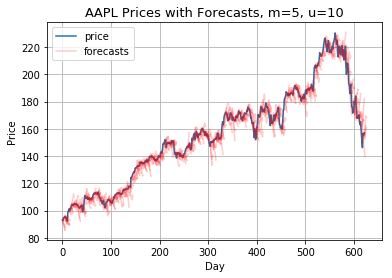

<Figure size 432x288 with 0 Axes>

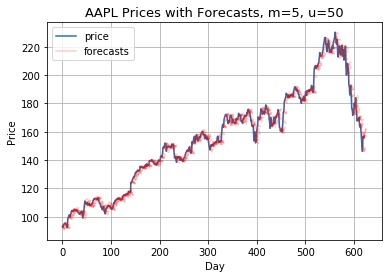

<Figure size 432x288 with 0 Axes>

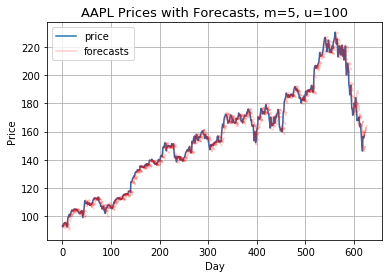




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 5/2142 [00:00<00:47, 45.25it/s]


  0%|          | 10/2142 [00:00<00:46, 45.64it/s]


  1%|          | 15/2142 [00:00<00:46, 46.21it/s]


  1%|          | 20/2142 [00:00<00:45, 46.66it/s]


  1%|          | 25/2142 [00:00<00:45, 46.68it/s]


  1%|▏         | 30/2142 [00:00<00:45, 46.63it/s]


  2%|▏         | 35/2142 [00:00<00:45, 45.90it/s]


  2%|▏         | 40/2142 [00:00<00:45, 45.85it/s]


  2%|▏         | 45/2142 [00:00<00:45, 46.34it/s]


  2%|▏         | 50/2142 [00:01<00:45, 45.92it/s]


  3%|▎         | 55/2142 [00:01<00:45, 45.83it/s]


  3%|▎         | 60/2142 [00:01<00:46, 45.20it/s]


  3%|▎         | 65/2142 [00:01<00:46, 45.07it/s]


  3%|▎         | 70/2142 [00:01<00:46, 44.90it/s]


  4%|▎         | 75/2142 [00:01<00:45, 45.20it/s]


  4%|▎         | 80/2142 [00:01<00:45, 45.46it/s]


  4%|▍         | 85/2142 [00:01<00:45, 44.80it/s]


  4%|▍         | 90/2142 [00:01<00:45, 45.46it/s]


  4%|▍         | 95

<Figure size 432x288 with 0 Axes>

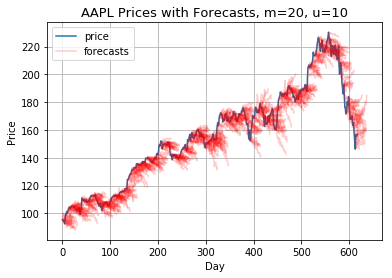

<Figure size 432x288 with 0 Axes>

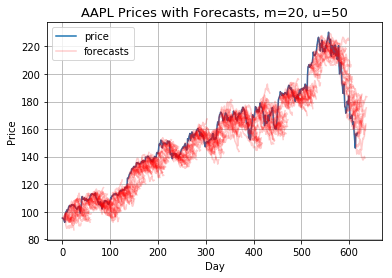

<Figure size 432x288 with 0 Axes>

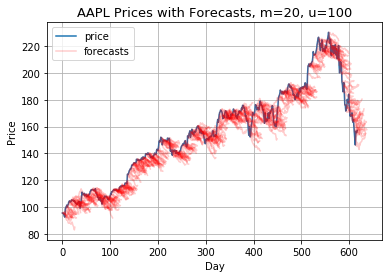




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 4/2142 [00:00<01:04, 33.04it/s]


  0%|          | 8/2142 [00:00<01:04, 33.02it/s]


  1%|          | 12/2142 [00:00<01:04, 33.08it/s]


  1%|          | 16/2142 [00:00<01:04, 33.04it/s]


  1%|          | 20/2142 [00:00<01:04, 33.09it/s]


  1%|          | 24/2142 [00:00<01:03, 33.36it/s]


  1%|▏         | 28/2142 [00:00<01:03, 33.35it/s]


  1%|▏         | 32/2142 [00:00<01:03, 33.43it/s]


  2%|▏         | 36/2142 [00:01<01:02, 33.49it/s]


  2%|▏         | 40/2142 [00:01<01:03, 32.94it/s]


  2%|▏         | 44/2142 [00:01<01:04, 32.35it/s]


  2%|▏         | 48/2142 [00:01<01:04, 32.40it/s]


  2%|▏         | 52/2142 [00:01<01:03, 32.71it/s]


  3%|▎         | 56/2142 [00:01<01:02, 33.23it/s]


  3%|▎         | 60/2142 [00:01<01:02, 33.32it/s]


  3%|▎         | 64/2142 [00:01<01:03, 32.87it/s]


  3%|▎         | 68/2142 [00:02<01:04, 32.33it/s]


  3%|▎         | 72/2142 [00:02<01:05, 31.73it/s]


  4%|▎         | 76/

<Figure size 432x288 with 0 Axes>

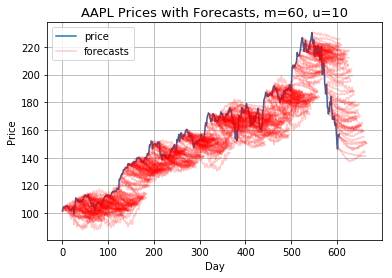

<Figure size 432x288 with 0 Axes>

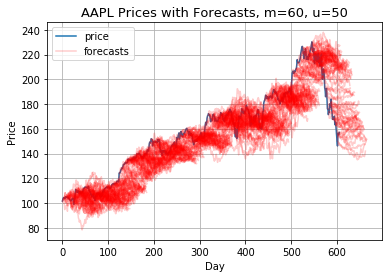

<Figure size 432x288 with 0 Axes>

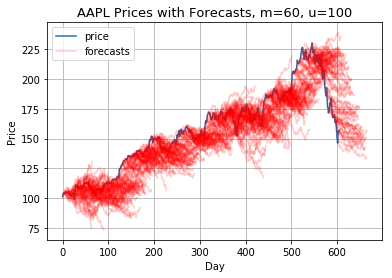




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 6/2142 [00:00<00:39, 53.55it/s]


  1%|          | 12/2142 [00:00<00:39, 54.22it/s]


  1%|          | 18/2142 [00:00<00:38, 54.64it/s]


  1%|          | 24/2142 [00:00<00:38, 54.61it/s]


  1%|▏         | 30/2142 [00:00<00:38, 54.50it/s]


  2%|▏         | 36/2142 [00:00<00:38, 54.69it/s]


  2%|▏         | 42/2142 [00:00<00:38, 54.25it/s]


  2%|▏         | 48/2142 [00:00<00:38, 54.41it/s]


  3%|▎         | 54/2142 [00:00<00:38, 54.76it/s]


  3%|▎         | 60/2142 [00:01<00:37, 55.05it/s]


  3%|▎         | 66/2142 [00:01<00:37, 54.87it/s]


  3%|▎         | 72/2142 [00:01<00:37, 54.81it/s]


  4%|▎         | 78/2142 [00:01<00:37, 54.94it/s]


  4%|▍         | 84/2142 [00:01<00:37, 54.58it/s]


  4%|▍         | 90/2142 [00:01<00:37, 54.73it/s]


  4%|▍         | 96/2142 [00:01<00:36, 55.31it/s]


  5%|▍         | 102/2142 [00:01<00:36, 55.31it/s]


  5%|▌         | 108/2142 [00:01<00:36, 55.27it/s]


  5%|▌         | 

<Figure size 432x288 with 0 Axes>

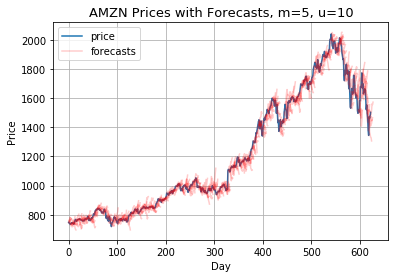

<Figure size 432x288 with 0 Axes>

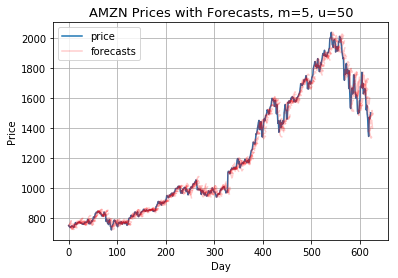

<Figure size 432x288 with 0 Axes>

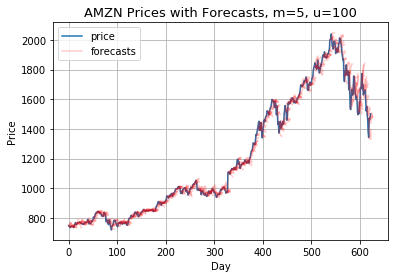




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 5/2142 [00:00<00:48, 44.51it/s]


  0%|          | 10/2142 [00:00<00:47, 45.12it/s]


  1%|          | 15/2142 [00:00<00:46, 45.27it/s]


  1%|          | 20/2142 [00:00<00:46, 45.22it/s]


  1%|          | 25/2142 [00:00<00:47, 44.77it/s]


  1%|▏         | 30/2142 [00:00<00:46, 45.21it/s]


  2%|▏         | 35/2142 [00:00<00:46, 45.23it/s]


  2%|▏         | 40/2142 [00:00<00:46, 45.62it/s]


  2%|▏         | 45/2142 [00:00<00:45, 45.70it/s]


  2%|▏         | 50/2142 [00:01<00:46, 44.96it/s]


  3%|▎         | 55/2142 [00:01<00:46, 45.33it/s]


  3%|▎         | 60/2142 [00:01<00:45, 45.33it/s]


  3%|▎         | 65/2142 [00:01<00:45, 45.54it/s]


  3%|▎         | 70/2142 [00:01<00:45, 45.78it/s]


  4%|▎         | 75/2142 [00:01<00:44, 45.97it/s]


  4%|▎         | 80/2142 [00:01<00:44, 45.87it/s]


  4%|▍         | 85/2142 [00:01<00:44, 45.74it/s]


  4%|▍         | 90/2142 [00:01<00:44, 45.81it/s]


  4%|▍         | 95

<Figure size 432x288 with 0 Axes>

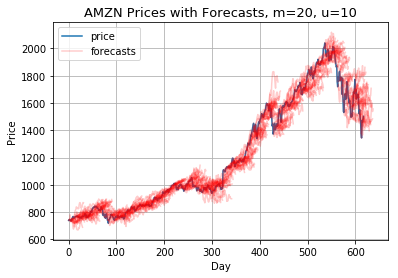

<Figure size 432x288 with 0 Axes>

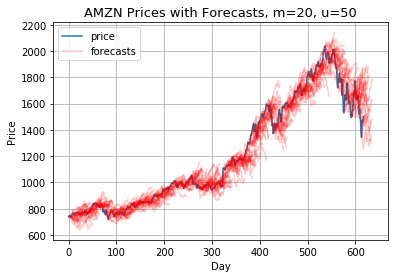

<Figure size 432x288 with 0 Axes>

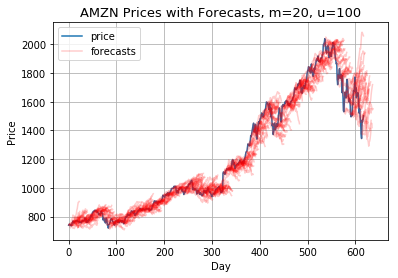




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 4/2142 [00:00<01:03, 33.64it/s]


  0%|          | 8/2142 [00:00<01:03, 33.43it/s]


  1%|          | 12/2142 [00:00<01:03, 33.62it/s]


  1%|          | 16/2142 [00:00<01:03, 33.60it/s]


  1%|          | 20/2142 [00:00<01:03, 33.33it/s]


  1%|          | 24/2142 [00:00<01:03, 33.55it/s]


  1%|▏         | 28/2142 [00:00<01:02, 33.58it/s]


  1%|▏         | 32/2142 [00:00<01:03, 33.04it/s]


  2%|▏         | 36/2142 [00:01<01:03, 33.12it/s]


  2%|▏         | 40/2142 [00:01<01:02, 33.43it/s]


  2%|▏         | 44/2142 [00:01<01:03, 33.11it/s]


  2%|▏         | 48/2142 [00:01<01:03, 32.94it/s]


  2%|▏         | 52/2142 [00:01<01:04, 32.53it/s]


  3%|▎         | 56/2142 [00:01<01:04, 32.14it/s]


  3%|▎         | 60/2142 [00:01<01:03, 32.61it/s]


  3%|▎         | 64/2142 [00:01<01:03, 32.86it/s]


  3%|▎         | 68/2142 [00:02<01:02, 33.23it/s]


  3%|▎         | 72/2142 [00:02<01:01, 33.64it/s]


  4%|▎         | 76/

<Figure size 432x288 with 0 Axes>

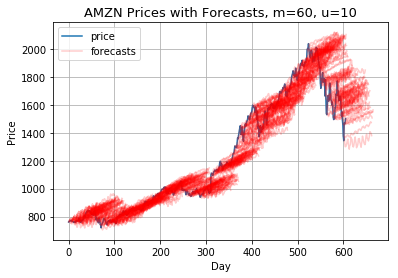

<Figure size 432x288 with 0 Axes>

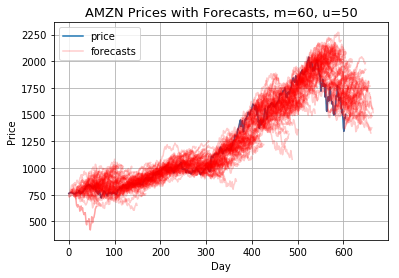

<Figure size 432x288 with 0 Axes>

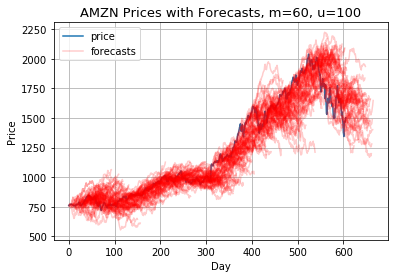




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 6/2142 [00:00<00:39, 54.02it/s]


  1%|          | 12/2142 [00:00<00:38, 54.67it/s]


  1%|          | 18/2142 [00:00<00:39, 54.30it/s]


  1%|          | 24/2142 [00:00<00:38, 54.36it/s]


  1%|▏         | 30/2142 [00:00<00:38, 54.19it/s]


  2%|▏         | 36/2142 [00:00<00:38, 54.52it/s]


  2%|▏         | 42/2142 [00:00<00:38, 54.90it/s]


  2%|▏         | 48/2142 [00:00<00:37, 55.47it/s]


  3%|▎         | 54/2142 [00:00<00:37, 55.81it/s]


  3%|▎         | 60/2142 [00:01<00:37, 55.42it/s]


  3%|▎         | 66/2142 [00:01<00:37, 54.97it/s]


  3%|▎         | 72/2142 [00:01<00:37, 55.16it/s]


  4%|▎         | 78/2142 [00:01<00:37, 54.99it/s]


  4%|▍         | 84/2142 [00:01<00:37, 55.22it/s]


  4%|▍         | 90/2142 [00:01<00:37, 55.37it/s]


  4%|▍         | 96/2142 [00:01<00:36, 55.50it/s]


  5%|▍         | 102/2142 [00:01<00:36, 56.03it/s]


  5%|▌         | 108/2142 [00:01<00:36, 56.27it/s]


  5%|▌         | 

<Figure size 432x288 with 0 Axes>

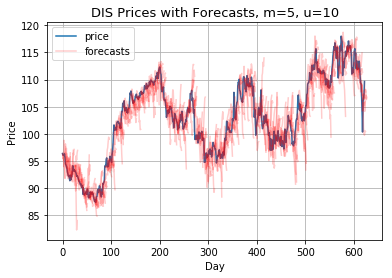

<Figure size 432x288 with 0 Axes>

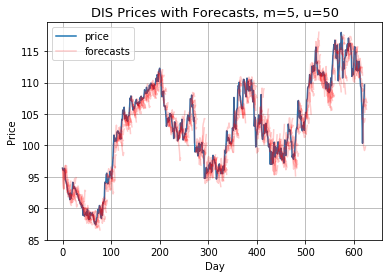

<Figure size 432x288 with 0 Axes>

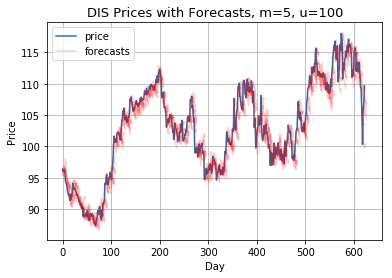




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 5/2142 [00:00<00:48, 44.07it/s]


  0%|          | 10/2142 [00:00<00:47, 44.89it/s]


  1%|          | 15/2142 [00:00<00:47, 44.97it/s]


  1%|          | 20/2142 [00:00<00:47, 45.03it/s]


  1%|          | 25/2142 [00:00<00:47, 44.76it/s]


  1%|▏         | 30/2142 [00:00<00:46, 45.49it/s]


  2%|▏         | 35/2142 [00:00<00:45, 45.82it/s]


  2%|▏         | 40/2142 [00:00<00:46, 45.44it/s]


  2%|▏         | 45/2142 [00:00<00:45, 45.70it/s]


  2%|▏         | 50/2142 [00:01<00:45, 45.89it/s]


  3%|▎         | 55/2142 [00:01<00:45, 45.69it/s]


  3%|▎         | 60/2142 [00:01<00:45, 45.51it/s]


  3%|▎         | 65/2142 [00:01<00:45, 45.63it/s]


  3%|▎         | 70/2142 [00:01<00:45, 45.36it/s]


  4%|▎         | 75/2142 [00:01<00:45, 45.59it/s]


  4%|▎         | 80/2142 [00:01<00:44, 46.22it/s]


  4%|▍         | 85/2142 [00:01<00:44, 46.11it/s]


  4%|▍         | 90/2142 [00:01<00:44, 45.62it/s]


  4%|▍         | 95

<Figure size 432x288 with 0 Axes>

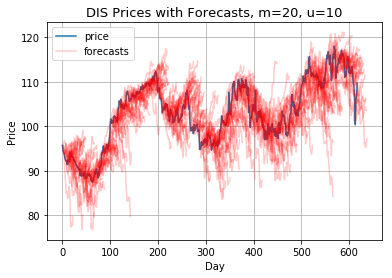

<Figure size 432x288 with 0 Axes>

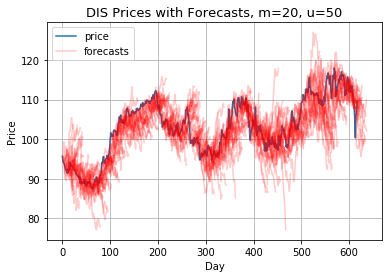

<Figure size 432x288 with 0 Axes>

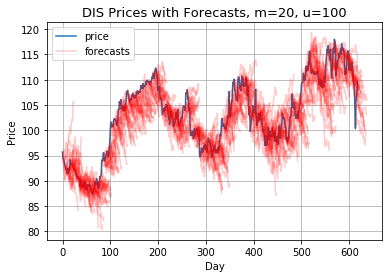




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 4/2142 [00:00<01:08, 31.25it/s]


  0%|          | 8/2142 [00:00<01:07, 31.61it/s]


  1%|          | 12/2142 [00:00<01:06, 31.97it/s]


  1%|          | 16/2142 [00:00<01:06, 32.09it/s]


  1%|          | 20/2142 [00:00<01:05, 32.22it/s]


  1%|          | 24/2142 [00:00<01:06, 32.08it/s]


  1%|▏         | 27/2142 [00:00<01:07, 31.29it/s]


  1%|▏         | 31/2142 [00:00<01:07, 31.48it/s]


  2%|▏         | 35/2142 [00:01<01:06, 31.48it/s]


  2%|▏         | 39/2142 [00:01<01:07, 31.35it/s]


  2%|▏         | 43/2142 [00:01<01:07, 31.20it/s]


  2%|▏         | 47/2142 [00:01<01:06, 31.47it/s]


  2%|▏         | 51/2142 [00:01<01:06, 31.39it/s]


  3%|▎         | 55/2142 [00:01<01:06, 31.24it/s]


  3%|▎         | 59/2142 [00:01<01:04, 32.10it/s]


  3%|▎         | 63/2142 [00:01<01:04, 32.41it/s]


  3%|▎         | 67/2142 [00:02<01:04, 32.39it/s]


  3%|▎         | 71/2142 [00:02<01:03, 32.38it/s]


  4%|▎         | 75/

<Figure size 432x288 with 0 Axes>

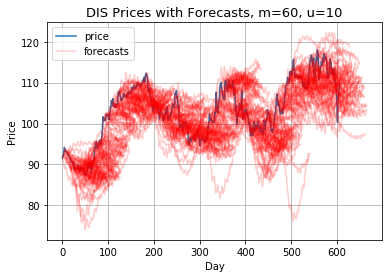

<Figure size 432x288 with 0 Axes>

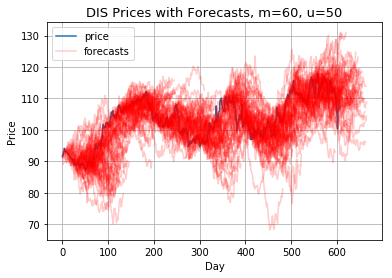

<Figure size 432x288 with 0 Axes>

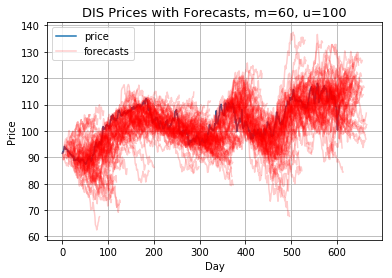




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 6/2142 [00:00<00:40, 53.09it/s]


  1%|          | 12/2142 [00:00<00:39, 53.43it/s]


  1%|          | 18/2142 [00:00<00:39, 54.11it/s]


  1%|          | 24/2142 [00:00<00:38, 54.56it/s]


  1%|▏         | 30/2142 [00:00<00:38, 54.59it/s]


  2%|▏         | 36/2142 [00:00<00:38, 54.60it/s]


  2%|▏         | 42/2142 [00:00<00:38, 54.61it/s]


  2%|▏         | 48/2142 [00:00<00:38, 54.72it/s]


  3%|▎         | 54/2142 [00:00<00:38, 54.73it/s]


  3%|▎         | 60/2142 [00:01<00:37, 54.98it/s]


  3%|▎         | 66/2142 [00:01<00:37, 54.93it/s]


  3%|▎         | 72/2142 [00:01<00:37, 54.80it/s]


  4%|▎         | 78/2142 [00:01<00:37, 54.58it/s]


  4%|▍         | 84/2142 [00:01<00:38, 54.12it/s]


  4%|▍         | 90/2142 [00:01<00:37, 54.57it/s]


  4%|▍         | 96/2142 [00:01<00:37, 54.54it/s]


  5%|▍         | 102/2142 [00:01<00:37, 54.62it/s]


  5%|▌         | 108/2142 [00:01<00:37, 54.39it/s]


  5%|▌         | 

<Figure size 432x288 with 0 Axes>

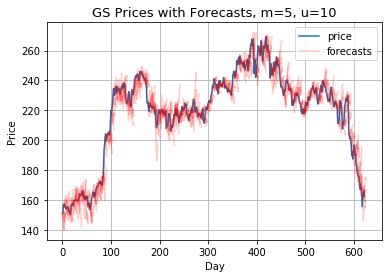

<Figure size 432x288 with 0 Axes>

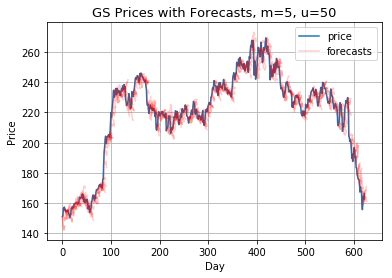

<Figure size 432x288 with 0 Axes>

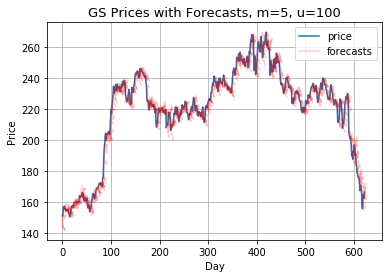




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 5/2142 [00:00<00:46, 45.73it/s]


  0%|          | 10/2142 [00:00<00:46, 45.51it/s]


  1%|          | 15/2142 [00:00<00:46, 45.30it/s]


  1%|          | 20/2142 [00:00<00:46, 45.82it/s]


  1%|          | 25/2142 [00:00<00:45, 46.27it/s]


  1%|▏         | 30/2142 [00:00<00:45, 46.46it/s]


  2%|▏         | 35/2142 [00:00<00:45, 46.38it/s]


  2%|▏         | 40/2142 [00:00<00:45, 45.73it/s]


  2%|▏         | 45/2142 [00:00<00:45, 45.83it/s]


  2%|▏         | 50/2142 [00:01<00:46, 45.17it/s]


  3%|▎         | 55/2142 [00:01<00:45, 45.46it/s]


  3%|▎         | 60/2142 [00:01<00:46, 45.24it/s]


  3%|▎         | 65/2142 [00:01<00:45, 45.37it/s]


  3%|▎         | 70/2142 [00:01<00:46, 44.96it/s]


  4%|▎         | 75/2142 [00:01<00:45, 45.13it/s]


  4%|▎         | 80/2142 [00:01<00:45, 45.40it/s]


  4%|▍         | 85/2142 [00:01<00:45, 45.67it/s]


  4%|▍         | 90/2142 [00:01<00:44, 46.42it/s]


  4%|▍         | 95

<Figure size 432x288 with 0 Axes>

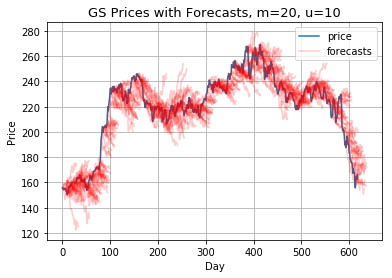

<Figure size 432x288 with 0 Axes>

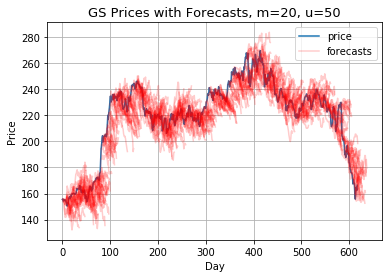

<Figure size 432x288 with 0 Axes>

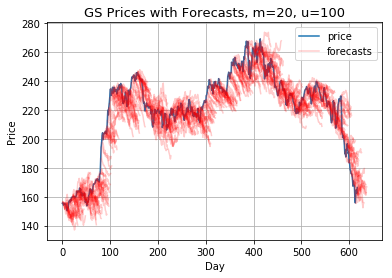




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 4/2142 [00:00<01:07, 31.81it/s]


  0%|          | 8/2142 [00:00<01:06, 32.11it/s]


  1%|          | 12/2142 [00:00<01:05, 32.40it/s]


  1%|          | 16/2142 [00:00<01:04, 33.01it/s]


  1%|          | 20/2142 [00:00<01:04, 33.09it/s]


  1%|          | 24/2142 [00:00<01:03, 33.31it/s]


  1%|▏         | 28/2142 [00:00<01:03, 33.22it/s]


  1%|▏         | 32/2142 [00:00<01:02, 33.64it/s]


  2%|▏         | 36/2142 [00:01<01:02, 33.89it/s]


  2%|▏         | 40/2142 [00:01<01:02, 33.60it/s]


  2%|▏         | 44/2142 [00:01<01:03, 33.09it/s]


  2%|▏         | 48/2142 [00:01<01:02, 33.38it/s]


  2%|▏         | 52/2142 [00:01<01:03, 32.96it/s]


  3%|▎         | 56/2142 [00:01<01:03, 32.61it/s]


  3%|▎         | 60/2142 [00:01<01:04, 32.40it/s]


  3%|▎         | 64/2142 [00:01<01:04, 32.29it/s]


  3%|▎         | 68/2142 [00:02<01:03, 32.43it/s]


  3%|▎         | 72/2142 [00:02<01:03, 32.55it/s]


  4%|▎         | 76/

<Figure size 432x288 with 0 Axes>

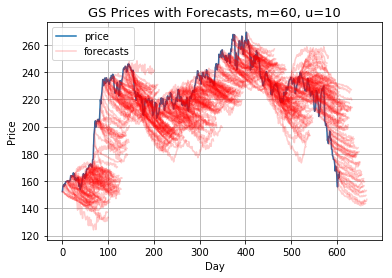

<Figure size 432x288 with 0 Axes>

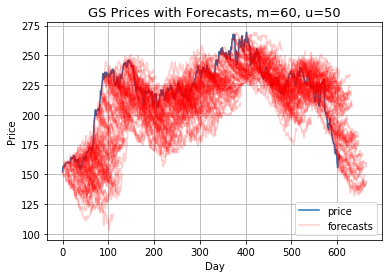

<Figure size 432x288 with 0 Axes>

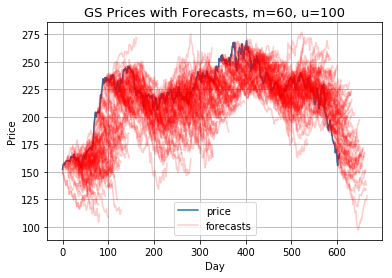




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 6/2142 [00:00<00:41, 51.49it/s]


  1%|          | 12/2142 [00:00<00:41, 51.86it/s]


  1%|          | 18/2142 [00:00<00:41, 51.78it/s]


  1%|          | 24/2142 [00:00<00:40, 52.07it/s]


  1%|▏         | 30/2142 [00:00<00:40, 52.40it/s]


  2%|▏         | 36/2142 [00:00<00:39, 52.70it/s]


  2%|▏         | 41/2142 [00:00<00:40, 51.84it/s]


  2%|▏         | 47/2142 [00:00<00:40, 52.12it/s]


  2%|▏         | 53/2142 [00:01<00:39, 52.29it/s]


  3%|▎         | 59/2142 [00:01<00:40, 51.45it/s]


  3%|▎         | 65/2142 [00:01<00:40, 51.25it/s]


  3%|▎         | 71/2142 [00:01<00:40, 50.93it/s]


  4%|▎         | 77/2142 [00:01<00:40, 51.50it/s]


  4%|▍         | 83/2142 [00:01<00:39, 51.84it/s]


  4%|▍         | 89/2142 [00:01<00:39, 52.28it/s]


  4%|▍         | 95/2142 [00:01<00:38, 52.61it/s]


  5%|▍         | 101/2142 [00:01<00:39, 51.81it/s]


  5%|▍         | 107/2142 [00:02<00:39, 51.66it/s]


  5%|▌         | 

<Figure size 432x288 with 0 Axes>

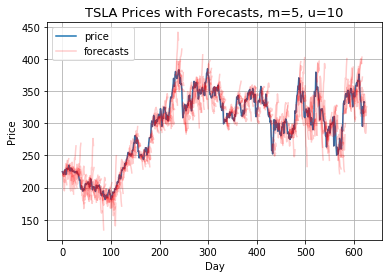

<Figure size 432x288 with 0 Axes>

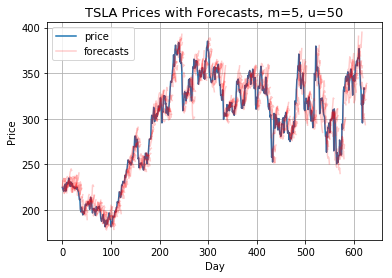

<Figure size 432x288 with 0 Axes>

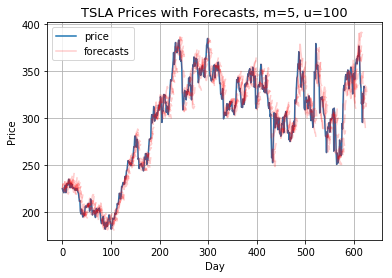




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 5/2142 [00:00<00:47, 45.45it/s]


  0%|          | 10/2142 [00:00<00:46, 46.14it/s]


  1%|          | 15/2142 [00:00<00:46, 46.05it/s]


  1%|          | 20/2142 [00:00<00:46, 46.01it/s]


  1%|          | 25/2142 [00:00<00:45, 46.39it/s]


  1%|▏         | 30/2142 [00:00<00:45, 46.70it/s]


  2%|▏         | 35/2142 [00:00<00:45, 46.22it/s]


  2%|▏         | 40/2142 [00:00<00:45, 45.78it/s]


  2%|▏         | 45/2142 [00:00<00:46, 45.26it/s]


  2%|▏         | 50/2142 [00:01<00:46, 45.20it/s]


  3%|▎         | 55/2142 [00:01<00:45, 45.71it/s]


  3%|▎         | 60/2142 [00:01<00:45, 46.14it/s]


  3%|▎         | 65/2142 [00:01<00:44, 46.42it/s]


  3%|▎         | 70/2142 [00:01<00:44, 46.51it/s]


  4%|▎         | 75/2142 [00:01<00:44, 46.58it/s]


  4%|▎         | 80/2142 [00:01<00:44, 46.39it/s]


  4%|▍         | 85/2142 [00:01<00:44, 46.32it/s]


  4%|▍         | 90/2142 [00:01<00:44, 46.41it/s]


  4%|▍         | 95

<Figure size 432x288 with 0 Axes>

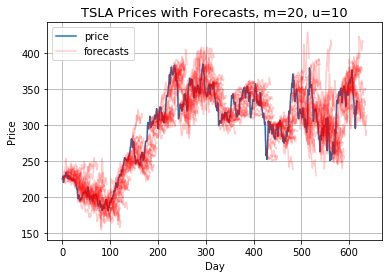

<Figure size 432x288 with 0 Axes>

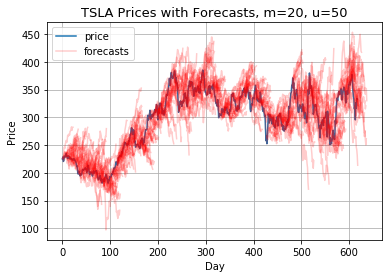

<Figure size 432x288 with 0 Axes>

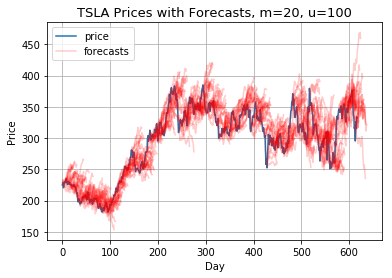




  0%|          | 0/2142 [00:00<?, ?it/s]


  0%|          | 4/2142 [00:00<01:04, 32.89it/s]


  0%|          | 8/2142 [00:00<01:03, 33.45it/s]


  1%|          | 12/2142 [00:00<01:04, 33.27it/s]


  1%|          | 16/2142 [00:00<01:03, 33.24it/s]


  1%|          | 20/2142 [00:00<01:03, 33.16it/s]


  1%|          | 24/2142 [00:00<01:02, 33.65it/s]


  1%|▏         | 28/2142 [00:00<01:02, 33.62it/s]


  1%|▏         | 32/2142 [00:00<01:02, 33.82it/s]


  2%|▏         | 36/2142 [00:01<01:02, 33.78it/s]


  2%|▏         | 40/2142 [00:01<01:01, 34.11it/s]


  2%|▏         | 44/2142 [00:01<01:01, 34.00it/s]


  2%|▏         | 48/2142 [00:01<01:01, 34.12it/s]


  2%|▏         | 52/2142 [00:01<01:02, 33.70it/s]


  3%|▎         | 56/2142 [00:01<01:03, 33.11it/s]


  3%|▎         | 60/2142 [00:01<01:03, 32.59it/s]


  3%|▎         | 64/2142 [00:01<01:03, 32.61it/s]


  3%|▎         | 68/2142 [00:02<01:03, 32.46it/s]


  3%|▎         | 72/2142 [00:02<01:03, 32.83it/s]


  4%|▎         | 76/

<Figure size 432x288 with 0 Axes>

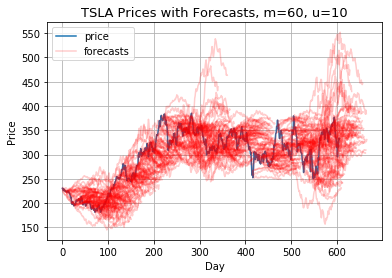

<Figure size 432x288 with 0 Axes>

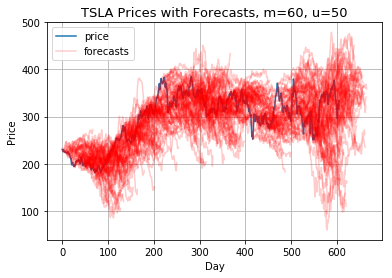

<Figure size 432x288 with 0 Axes>

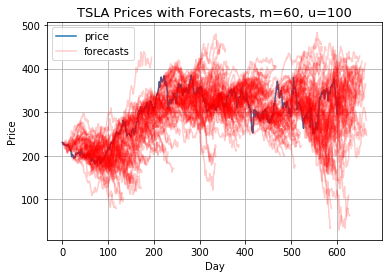

In [37]:
# lstm news forecast plots
n_neuronss = [10, 50, 100]
model_name = 'news'
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]
    for n_seq in [5, 20, 60]: 

        # generate inputs
        series, scaler, train, test, n_test = generate_inputs(sym, name)
        series, n_test, scaler_mult, train_mult, test_mult = generate_inputs_mv(sym, name, 'onegram')

        for j in range(len(n_neuronss)):
            n_neurons = n_neuronss[j]
            
            # load model and loss
            model = load_keras_model(model_name, name, n_epochs, n_neurons, n_lag, n_seq)

            # make forecasts
            forecasts = make_forecasts_mv(model, n_batch, train_mult, test_mult, n_lag, n_seq)

            # inverse transform forecasts and test
            forecasts = inverse_transform(series, forecasts, scaler_mult, n_test)
            actual = [row[n_lag:] for row in test_mult[:,-1,:]]
            actual = inverse_transform(series, actual, scaler_mult, n_test)
        
            # plot forecasts and save
            plt.figure()
            plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)
            plt.savefig('plots/fplots_{}_{}_{}_{}.png'.format(model_name, name, n_seq, n_neurons))   
            plt.show()

<Figure size 432x288 with 0 Axes>

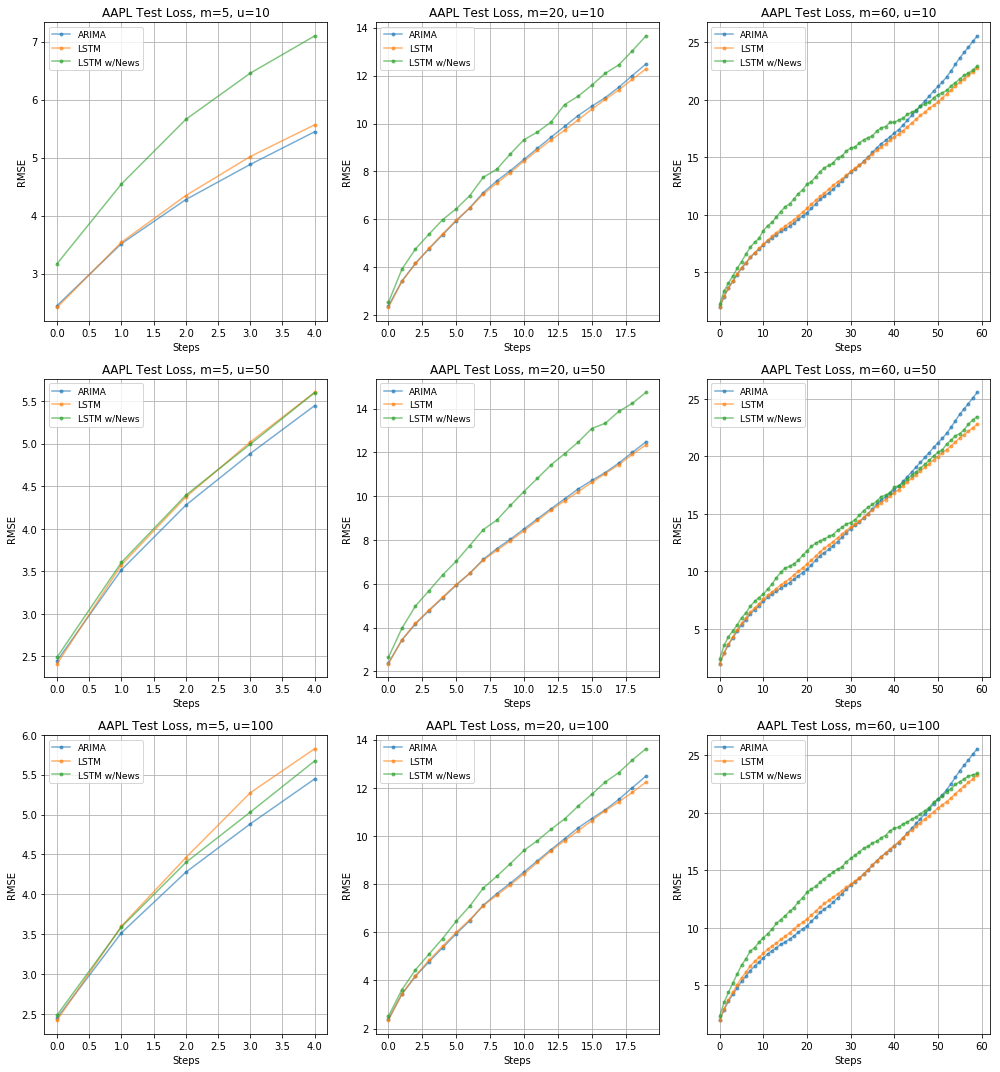

<Figure size 432x288 with 0 Axes>

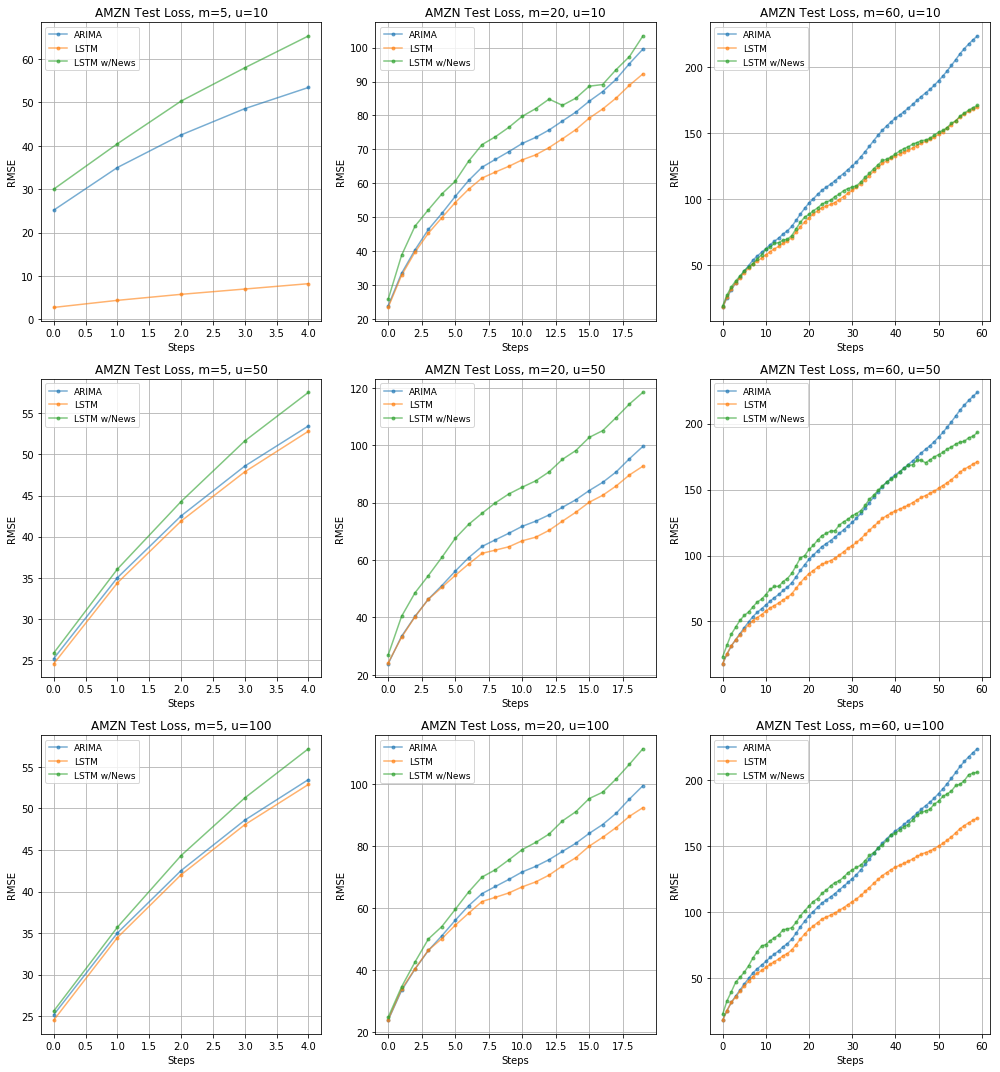

<Figure size 432x288 with 0 Axes>

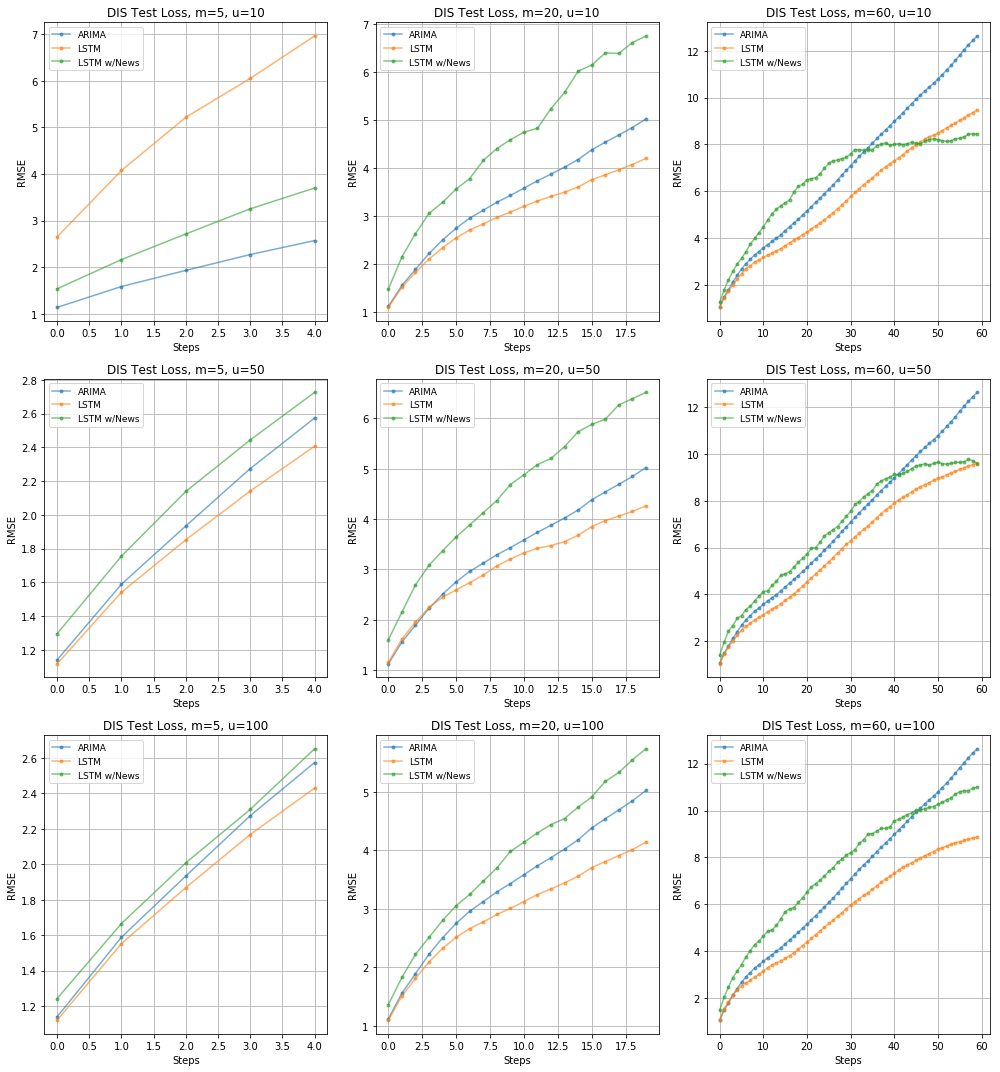

<Figure size 432x288 with 0 Axes>

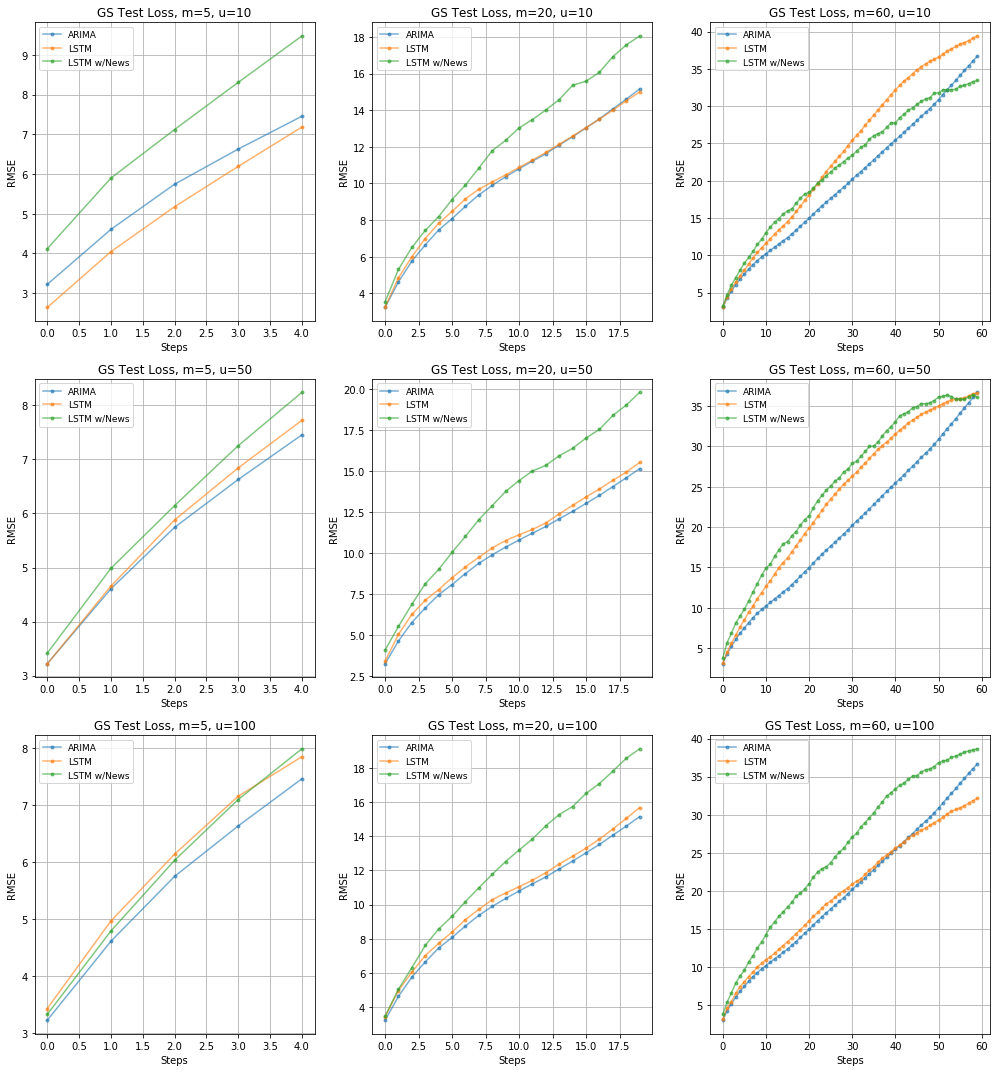

<Figure size 432x288 with 0 Axes>

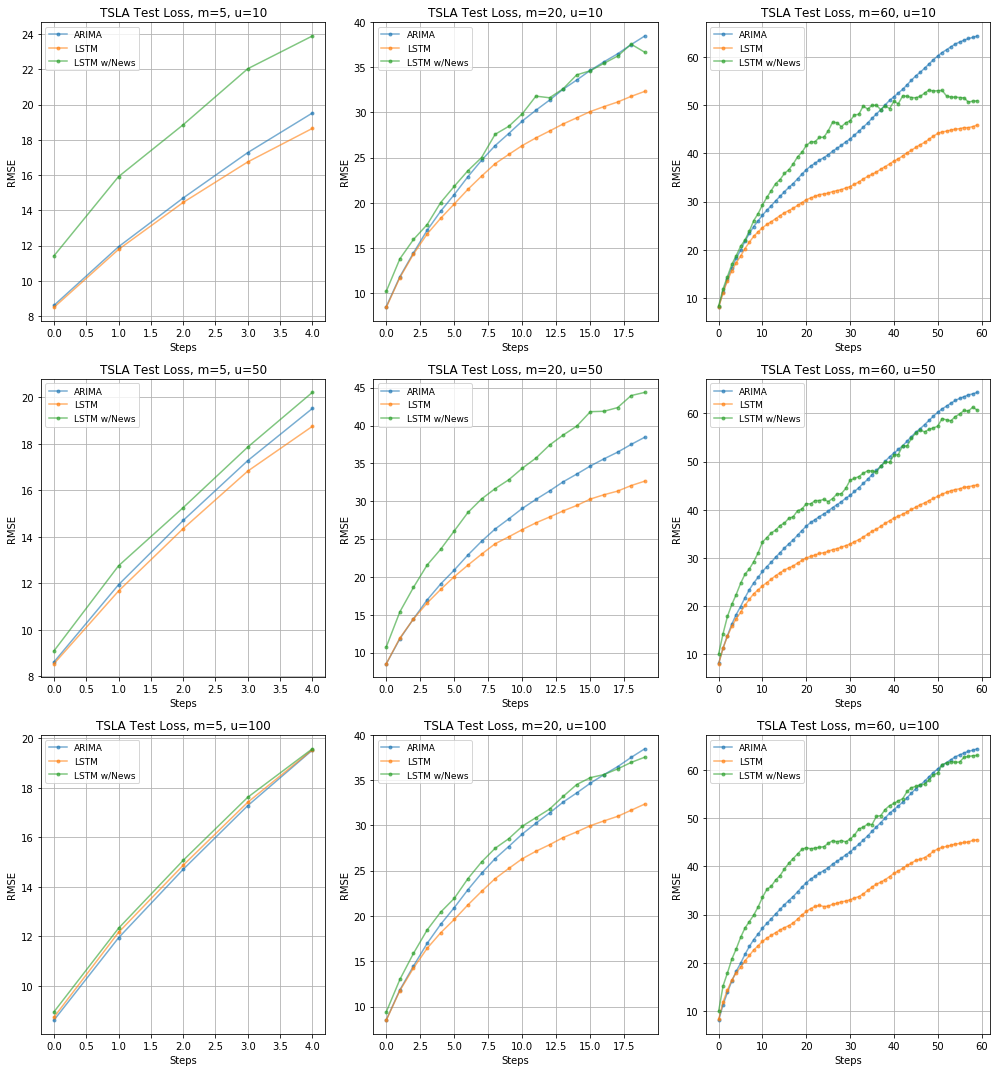

In [41]:
# compare loss between all models
n_seqs = [5, 20, 60]
n_neuronss = [10, 50, 100]
for i in range(len(ticker2name)):
    sym = list(ticker2name.keys())[i]
    name = ticker2name[sym]    
    plt.figure()
    f, axarr = plt.subplots(3, 3, figsize=(14,15))
    for j in range(len(n_neuronss)):
        n_neurons = n_neuronss[j]
        for k in range(len(n_seqs)):
            n_seq = n_seqs[k]
            
            # load losses
            model_name = 'arima'
            test_loss_arima = load_test_rmses(model_name, name, n_epochs, 0, n_lag, n_seq)
            model_name = 'lstm'
            test_loss_lstm = load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            model_name = 'news'
            test_loss_news = load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
            
            # plot
            axarr[j,k].set_title('{} Test Loss, m={}, u={}'.format(sym, n_seq, n_neurons))#, fontsize=16)
            axarr[j,k].set_xlabel('Steps')#, fontsize=13)
            axarr[j,k].set_ylabel('RMSE')#, fontsize=13)
            axarr[j,k].plot(test_loss_arima, '.-', alpha=.6, label='ARIMA')
            axarr[j,k].plot(test_loss_lstm, '.-', alpha=.6, label='LSTM')
            axarr[j,k].plot(test_loss_news, '.-', alpha=.6, label='LSTM w/News')
            axarr[j,k].legend(fontsize=9)
            axarr[j,k].grid()
    plt.tight_layout()
    plt.savefig('plots/testloss_{}_{}_{}.png'.format('all', name, 'comparison'), bbox_inches='tight')   



  0%|          | 0/2142 [00:00<?, ?it/s]

  0%|          | 4/2142 [00:00<01:06, 31.97it/s]

news disney 50 10 60 60 bigram




  0%|          | 8/2142 [00:00<01:07, 31.74it/s]

  1%|          | 12/2142 [00:00<01:06, 32.06it/s]

  1%|          | 16/2142 [00:00<01:06, 31.86it/s]

  1%|          | 20/2142 [00:00<01:07, 31.48it/s]

  1%|          | 23/2142 [00:00<01:09, 30.61it/s]

  1%|▏         | 27/2142 [00:00<01:07, 31.28it/s]

  1%|▏         | 31/2142 [00:00<01:06, 31.56it/s]

  2%|▏         | 35/2142 [00:01<01:06, 31.72it/s]

  2%|▏         | 39/2142 [00:01<01:06, 31.73it/s]

  2%|▏         | 43/2142 [00:01<01:05, 32.04it/s]

  2%|▏         | 47/2142 [00:01<01:05, 31.80it/s]

  2%|▏         | 51/2142 [00:01<01:06, 31.65it/s]

  3%|▎         | 55/2142 [00:01<01:06, 31.33it/s]

  3%|▎         | 59/2142 [00:01<01:06, 31.37it/s]

  3%|▎         | 63/2142 [00:02<01:06, 31.16it/s]

  3%|▎         | 67/2142 [00:02<01:06, 31.20it/s]

  3%|▎         | 71/2142 [00:02<01:07, 30.84it/s]

  4%|▎         | 75/2142 [00:02<01:06, 30.91it/s]

  4%|▎         | 79/2142 [00:02<01:07, 30.61it/s]

  4%|▍         | 83/2142 [00:0

t+1 RMSE: 1.172171
t+2 RMSE: 1.736545
t+3 RMSE: 2.251290
t+4 RMSE: 2.597711
t+5 RMSE: 3.011549
t+6 RMSE: 3.295521
t+7 RMSE: 3.575825
t+8 RMSE: 3.802122
t+9 RMSE: 4.113744
t+10 RMSE: 4.352665
t+11 RMSE: 4.625277
t+12 RMSE: 4.992570
t+13 RMSE: 5.160841
t+14 RMSE: 5.422050
t+15 RMSE: 5.526829
t+16 RMSE: 5.796061
t+17 RMSE: 5.894817
t+18 RMSE: 6.209514
t+19 RMSE: 6.470781
t+20 RMSE: 6.631293
t+21 RMSE: 6.839225
t+22 RMSE: 7.112608
t+23 RMSE: 7.083288
t+24 RMSE: 7.141258
t+25 RMSE: 7.250233
t+26 RMSE: 7.431403
t+27 RMSE: 7.654848
t+28 RMSE: 7.875301
t+29 RMSE: 8.113475
t+30 RMSE: 8.176684
t+31 RMSE: 8.213899
t+32 RMSE: 8.256470
t+33 RMSE: 8.274178
t+34 RMSE: 8.320585
t+35 RMSE: 8.326593
t+36 RMSE: 8.477467
t+37 RMSE: 8.553170
t+38 RMSE: 8.611900
t+39 RMSE: 8.676358
t+40 RMSE: 8.584406
t+41 RMSE: 8.571874
t+42 RMSE: 8.537178
t+43 RMSE: 8.509087
t+44 RMSE: 8.438659
t+45 RMSE: 8.527427
t+46 RMSE: 8.580490
t+47 RMSE: 8.554767
t+48 RMSE: 8.560846
t+49 RMSE: 8.543993
t+50 RMSE: 8.494601
t+51 RMSE

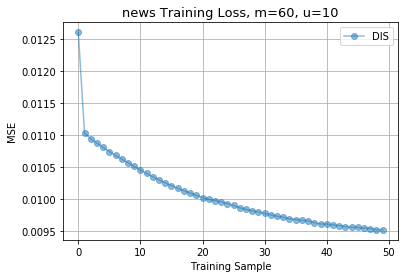



  0%|          | 0/2142 [00:00<?, ?it/s]

  0%|          | 4/2142 [00:00<01:03, 33.62it/s]

[-0.08022658 -0.04140001  0.04412103  0.01928929  0.12133711  0.16250678
  0.16608866  0.06032044  0.13199846  0.12214031  0.15320069  0.21969251
  0.12802015  0.18945003  0.14713374  0.29485556  0.27270981  0.24102293
  0.26497117  0.33608556  0.34690762  0.57760208  0.51670153  0.38601744
  0.2695534   0.23474253  0.35497366  0.54639535  0.72335514  0.7275538
  0.61389044  0.47937333  0.51162051  0.57016637  0.58521189  0.6999446
  0.60234971  0.6027477   0.61327783  0.62249258  0.57122224  0.50769611
  0.51586516  0.40854537  0.44186598  0.53781879  0.52950069  0.42034887
  0.3402734   0.25499717  0.26602394  0.26912495  0.39077862  0.33758532
  0.29638499  0.41258678  0.36377399  0.31389838  0.3524817   0.34554159]
news disney 50 10 60 60 trigram




  0%|          | 8/2142 [00:00<01:03, 33.70it/s]

  1%|          | 12/2142 [00:00<01:03, 33.42it/s]

  1%|          | 16/2142 [00:00<01:03, 33.63it/s]

  1%|          | 20/2142 [00:00<01:03, 33.67it/s]

  1%|          | 24/2142 [00:00<01:03, 33.37it/s]

  1%|▏         | 28/2142 [00:00<01:02, 33.91it/s]

  1%|▏         | 32/2142 [00:00<01:02, 33.91it/s]

  2%|▏         | 36/2142 [00:01<01:02, 33.96it/s]

  2%|▏         | 40/2142 [00:01<01:01, 34.23it/s]

  2%|▏         | 44/2142 [00:01<01:01, 34.10it/s]

  2%|▏         | 48/2142 [00:01<01:01, 33.90it/s]

  2%|▏         | 52/2142 [00:01<01:02, 33.33it/s]

  3%|▎         | 56/2142 [00:01<01:02, 33.16it/s]

  3%|▎         | 60/2142 [00:01<01:03, 32.71it/s]

  3%|▎         | 64/2142 [00:01<01:04, 32.41it/s]

  3%|▎         | 68/2142 [00:02<01:03, 32.41it/s]

  3%|▎         | 72/2142 [00:02<01:03, 32.78it/s]

  4%|▎         | 76/2142 [00:02<01:03, 32.69it/s]

  4%|▎         | 80/2142 [00:02<01:02, 32.92it/s]

  4%|▍         | 84/2142 [00:0

t+1 RMSE: 1.306258
t+2 RMSE: 1.883279
t+3 RMSE: 2.300166
t+4 RMSE: 2.896294
t+5 RMSE: 3.096437
t+6 RMSE: 3.261073
t+7 RMSE: 3.522554
t+8 RMSE: 3.754694
t+9 RMSE: 4.161039
t+10 RMSE: 4.568775
t+11 RMSE: 5.014216
t+12 RMSE: 5.308132
t+13 RMSE: 5.646892
t+14 RMSE: 6.029376
t+15 RMSE: 6.287092
t+16 RMSE: 6.536146
t+17 RMSE: 6.768653
t+18 RMSE: 7.014550
t+19 RMSE: 7.248342
t+20 RMSE: 7.761071
t+21 RMSE: 8.221840
t+22 RMSE: 8.362741
t+23 RMSE: 8.643073
t+24 RMSE: 8.796162
t+25 RMSE: 8.928506
t+26 RMSE: 9.103101
t+27 RMSE: 9.471688
t+28 RMSE: 9.638328
t+29 RMSE: 9.711283
t+30 RMSE: 9.806422
t+31 RMSE: 10.120944
t+32 RMSE: 10.144159
t+33 RMSE: 10.322567
t+34 RMSE: 10.571897
t+35 RMSE: 10.556037
t+36 RMSE: 10.474959
t+37 RMSE: 10.547128
t+38 RMSE: 10.642332
t+39 RMSE: 10.561116
t+40 RMSE: 10.434297
t+41 RMSE: 10.354300
t+42 RMSE: 10.223635
t+43 RMSE: 10.118338
t+44 RMSE: 10.167819
t+45 RMSE: 10.063805
t+46 RMSE: 9.950227
t+47 RMSE: 9.800876
t+48 RMSE: 9.548480
t+49 RMSE: 9.485673
t+50 RMSE: 9.3

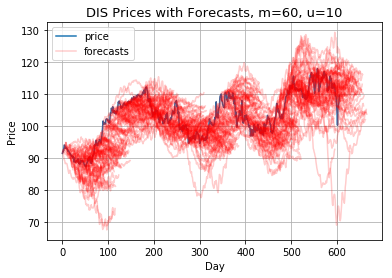

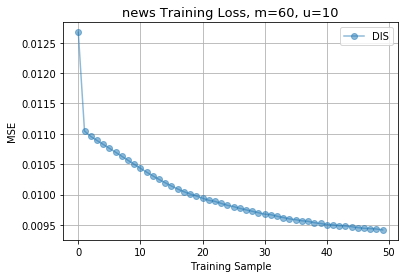



  0%|          | 0/2142 [00:00<?, ?it/s]

  0%|          | 4/2142 [00:00<01:03, 33.79it/s]

[0.05386095 0.10533349 0.09299723 0.31787179 0.20622555 0.1280585
 0.1128183  0.01289269 0.17929332 0.33824953 0.54213908 0.53525448
 0.61407102 0.79677553 0.90739701 1.03493997 1.14654513 1.0460586
 1.04253214 1.46586271 1.72952176 1.82773449 2.07648607 2.04092164
 1.94782721 1.9064402  2.17181365 2.30942271 2.32116341 2.35729125
 2.52093531 2.36706269 2.56000937 2.82147831 2.81465588 2.69743721
 2.59630752 2.63317985 2.4980364  2.47238292 2.3536484  2.19415301
 2.12511633 2.13770577 1.97824408 1.90755609 1.77560919 1.40798307
 1.28195284 1.14967307 1.1893771  1.11689997 1.00362065 0.79344939
 0.65267098 0.5737631  0.55514976 0.4714965  0.34955511 0.38326251]
news disney 50 50 60 60 bigram




  0%|          | 8/2142 [00:00<01:03, 33.73it/s]

  1%|          | 12/2142 [00:00<01:02, 33.96it/s]

  1%|          | 16/2142 [00:00<01:02, 34.02it/s]

  1%|          | 20/2142 [00:00<01:02, 33.72it/s]

  1%|          | 24/2142 [00:00<01:02, 33.88it/s]

  1%|▏         | 28/2142 [00:00<01:02, 33.69it/s]

  1%|▏         | 32/2142 [00:00<01:02, 33.50it/s]

  2%|▏         | 36/2142 [00:01<01:02, 33.62it/s]

  2%|▏         | 40/2142 [00:01<01:02, 33.53it/s]

  2%|▏         | 44/2142 [00:01<01:03, 33.09it/s]

  2%|▏         | 48/2142 [00:01<01:02, 33.27it/s]

  2%|▏         | 52/2142 [00:01<01:03, 33.14it/s]

  3%|▎         | 56/2142 [00:01<01:03, 33.09it/s]

  3%|▎         | 60/2142 [00:01<01:03, 32.63it/s]

  3%|▎         | 64/2142 [00:01<01:04, 32.27it/s]

  3%|▎         | 68/2142 [00:02<01:04, 32.17it/s]

  3%|▎         | 72/2142 [00:02<01:04, 32.07it/s]

  4%|▎         | 76/2142 [00:02<01:04, 32.06it/s]

  4%|▎         | 80/2142 [00:02<01:04, 31.94it/s]

  4%|▍         | 84/2142 [00:0

t+1 RMSE: 1.490050
t+2 RMSE: 2.029061
t+3 RMSE: 2.411671
t+4 RMSE: 2.782050
t+5 RMSE: 2.953420
t+6 RMSE: 3.185570
t+7 RMSE: 3.337808
t+8 RMSE: 3.445849
t+9 RMSE: 3.619369
t+10 RMSE: 3.784511
t+11 RMSE: 3.938141
t+12 RMSE: 4.215563
t+13 RMSE: 4.330920
t+14 RMSE: 4.507642
t+15 RMSE: 4.638543
t+16 RMSE: 4.814273
t+17 RMSE: 4.977861
t+18 RMSE: 5.335781
t+19 RMSE: 5.703302
t+20 RMSE: 5.868177
t+21 RMSE: 6.081732
t+22 RMSE: 6.289511
t+23 RMSE: 6.407294
t+24 RMSE: 6.597787
t+25 RMSE: 6.810734
t+26 RMSE: 7.127816
t+27 RMSE: 7.293408
t+28 RMSE: 7.582079
t+29 RMSE: 7.750987
t+30 RMSE: 7.966048
t+31 RMSE: 8.027956
t+32 RMSE: 8.205728
t+33 RMSE: 8.297045
t+34 RMSE: 8.487324
t+35 RMSE: 8.632233
t+36 RMSE: 8.696532
t+37 RMSE: 8.878131
t+38 RMSE: 8.990235
t+39 RMSE: 9.004892
t+40 RMSE: 9.145143
t+41 RMSE: 9.289315
t+42 RMSE: 9.394120
t+43 RMSE: 9.495615
t+44 RMSE: 9.538521
t+45 RMSE: 9.663323
t+46 RMSE: 9.695030
t+47 RMSE: 9.690696
t+48 RMSE: 9.625621
t+49 RMSE: 9.765372
t+50 RMSE: 9.833048
t+51 RMSE

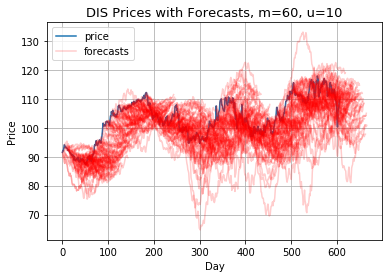

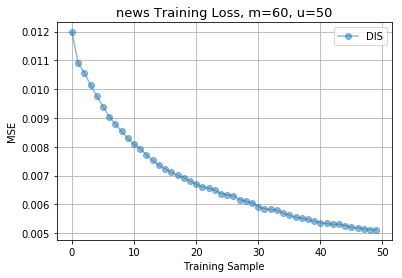



  0%|          | 0/2142 [00:00<?, ?it/s]

  0%|          | 4/2142 [00:00<01:06, 32.06it/s]

[ 0.0825049   0.07593803 -0.016585    0.11668852 -0.02859071  0.09815992
 -0.01542108 -0.04956982 -0.10373394 -0.13832071 -0.18340993  0.06457489
 -0.05348104 -0.04616512 -0.17181872 -0.06460833  0.00606053  0.16495703
  0.33597937  0.31745134  0.37052216  0.31733767  0.40700918  0.37268496
  0.30069736  0.48784014  0.52092305  0.68653667  0.6246944   0.63121123
  0.47763082  0.35652879  0.33613112  0.3152878   0.32790705  0.2568547
  0.15859765  0.14299916  0.05919955  0.14133875  0.15447077  0.28443518
  0.32153384  0.28364463  0.28328881  0.20073467  0.17096141  0.03853541
  0.24507884  0.23398426  0.24733496  0.34725888  0.33225101  0.27611265
  0.3101095   0.33321082  0.28207693  0.18678966  0.29196921  0.44501129]
news disney 50 50 60 60 trigram




  0%|          | 8/2142 [00:00<01:06, 32.09it/s]

  1%|          | 12/2142 [00:00<01:06, 32.27it/s]

  1%|          | 16/2142 [00:00<01:05, 32.59it/s]

  1%|          | 20/2142 [00:00<01:04, 32.84it/s]

  1%|          | 24/2142 [00:00<01:03, 33.11it/s]

  1%|▏         | 28/2142 [00:00<01:03, 33.35it/s]

  1%|▏         | 32/2142 [00:00<01:03, 33.35it/s]

  2%|▏         | 36/2142 [00:01<01:03, 33.41it/s]

  2%|▏         | 40/2142 [00:01<01:02, 33.44it/s]

  2%|▏         | 44/2142 [00:01<01:02, 33.39it/s]

  2%|▏         | 48/2142 [00:01<01:03, 33.07it/s]

  2%|▏         | 52/2142 [00:01<01:03, 33.16it/s]

  3%|▎         | 56/2142 [00:01<01:03, 32.84it/s]

  3%|▎         | 60/2142 [00:01<01:03, 32.78it/s]

  3%|▎         | 64/2142 [00:01<01:03, 32.82it/s]

  3%|▎         | 68/2142 [00:02<01:02, 33.01it/s]

  3%|▎         | 72/2142 [00:02<01:02, 33.28it/s]

  4%|▎         | 76/2142 [00:02<01:02, 32.94it/s]

  4%|▎         | 80/2142 [00:02<01:02, 33.18it/s]

  4%|▍         | 84/2142 [00:0

t+1 RMSE: 1.454085
t+2 RMSE: 2.069347
t+3 RMSE: 2.505266
t+4 RMSE: 2.915201
t+5 RMSE: 3.209825
t+6 RMSE: 3.324429
t+7 RMSE: 3.492984
t+8 RMSE: 3.670771
t+9 RMSE: 3.811405
t+10 RMSE: 3.991485
t+11 RMSE: 4.463346
t+12 RMSE: 4.774515
t+13 RMSE: 5.065276
t+14 RMSE: 5.183941
t+15 RMSE: 5.307491
t+16 RMSE: 5.430675
t+17 RMSE: 5.438244
t+18 RMSE: 5.810478
t+19 RMSE: 6.098677
t+20 RMSE: 6.194575
t+21 RMSE: 6.408960
t+22 RMSE: 6.783634
t+23 RMSE: 6.932313
t+24 RMSE: 7.098704
t+25 RMSE: 7.397571
t+26 RMSE: 7.341068
t+27 RMSE: 7.590030
t+28 RMSE: 7.720525
t+29 RMSE: 7.996257
t+30 RMSE: 8.236670
t+31 RMSE: 8.191256
t+32 RMSE: 8.359989
t+33 RMSE: 8.363920
t+34 RMSE: 8.545443
t+35 RMSE: 8.767741
t+36 RMSE: 9.000792
t+37 RMSE: 9.098311
t+38 RMSE: 9.219841
t+39 RMSE: 9.330347
t+40 RMSE: 9.477637
t+41 RMSE: 9.595197
t+42 RMSE: 9.581864
t+43 RMSE: 9.564451
t+44 RMSE: 9.678330
t+45 RMSE: 9.741510
t+46 RMSE: 9.917857
t+47 RMSE: 10.087655
t+48 RMSE: 10.203135
t+49 RMSE: 10.128964
t+50 RMSE: 10.078738
t+51 

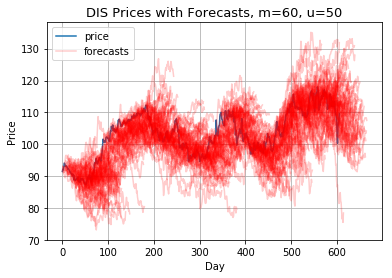

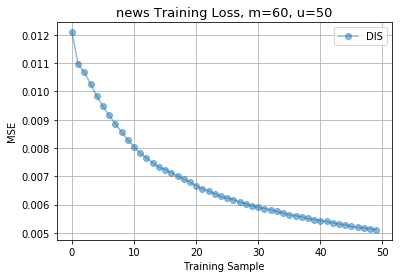



  0%|          | 0/2142 [00:00<?, ?it/s]

[0.04654001 0.11622429 0.07700984 0.24983951 0.22781439 0.23701851
 0.13975535 0.17535208 0.08830198 0.06865302 0.34179532 0.62352706
 0.68087562 0.63013427 0.49712963 0.55179319 0.46644389 0.63965364
 0.73135457 0.64385003 0.69775052 0.81145999 0.93202758 0.87360239
 0.88753447 0.70109204 0.81754543 0.82498236 0.86996464 0.9018328
 0.6409308  0.51078976 0.40300707 0.37340655 0.46341498 0.56111492
 0.37877697 0.37260507 0.38465466 0.47383319 0.46035262 0.47217903
 0.39036981 0.42345377 0.36147627 0.42356189 0.56792046 0.61604891
 0.60867125 0.47967435 0.48705978 0.35718851 0.27866336 0.44477407
 0.42093429 0.3446135  0.39123997 0.41052828 0.45670291 0.55166802]
news disney 50 100 60 60 bigram




  0%|          | 1/2142 [00:00<08:21,  4.27it/s]

  0%|          | 5/2142 [00:00<06:09,  5.78it/s]

  0%|          | 9/2142 [00:00<04:38,  7.67it/s]

  1%|          | 12/2142 [00:00<03:35,  9.86it/s]

  1%|          | 16/2142 [00:00<02:51, 12.40it/s]

  1%|          | 20/2142 [00:00<02:20, 15.14it/s]

  1%|          | 24/2142 [00:00<01:58, 17.90it/s]

  1%|▏         | 27/2142 [00:01<01:43, 20.35it/s]

  1%|▏         | 31/2142 [00:01<01:33, 22.52it/s]

  2%|▏         | 35/2142 [00:01<01:24, 24.84it/s]

  2%|▏         | 39/2142 [00:01<01:18, 26.65it/s]

  2%|▏         | 43/2142 [00:01<01:14, 28.16it/s]

  2%|▏         | 47/2142 [00:01<01:11, 29.24it/s]

  2%|▏         | 51/2142 [00:01<01:10, 29.72it/s]

  3%|▎         | 55/2142 [00:01<01:08, 30.48it/s]

  3%|▎         | 59/2142 [00:02<01:06, 31.36it/s]

  3%|▎         | 63/2142 [00:02<01:05, 31.89it/s]

  3%|▎         | 67/2142 [00:02<01:03, 32.45it/s]

  3%|▎         | 71/2142 [00:02<01:02, 33.15it/s]

  4%|▎         | 75/2142 [00:02<

t+1 RMSE: 1.486822
t+2 RMSE: 2.106708
t+3 RMSE: 2.493216
t+4 RMSE: 2.846904
t+5 RMSE: 3.161020
t+6 RMSE: 3.430649
t+7 RMSE: 3.776419
t+8 RMSE: 3.968687
t+9 RMSE: 4.165366
t+10 RMSE: 4.368052
t+11 RMSE: 4.600190
t+12 RMSE: 4.809701
t+13 RMSE: 4.937467
t+14 RMSE: 5.095170
t+15 RMSE: 5.342311
t+16 RMSE: 5.507415
t+17 RMSE: 5.697180
t+18 RMSE: 5.926494
t+19 RMSE: 6.137086
t+20 RMSE: 6.291538
t+21 RMSE: 6.471268
t+22 RMSE: 6.610848
t+23 RMSE: 6.726006
t+24 RMSE: 6.884993
t+25 RMSE: 7.091885
t+26 RMSE: 7.247494
t+27 RMSE: 7.314426
t+28 RMSE: 7.650654
t+29 RMSE: 7.884812
t+30 RMSE: 7.985873
t+31 RMSE: 8.111386
t+32 RMSE: 8.371778
t+33 RMSE: 8.504412
t+34 RMSE: 8.651670
t+35 RMSE: 8.794294
t+36 RMSE: 8.934745
t+37 RMSE: 9.152776
t+38 RMSE: 9.224517
t+39 RMSE: 9.330409
t+40 RMSE: 9.289361
t+41 RMSE: 9.301433
t+42 RMSE: 9.401010
t+43 RMSE: 9.458502
t+44 RMSE: 9.477693
t+45 RMSE: 9.634202
t+46 RMSE: 9.673769
t+47 RMSE: 9.625567
t+48 RMSE: 9.635413
t+49 RMSE: 9.670035
t+50 RMSE: 9.696703
t+51 RMSE

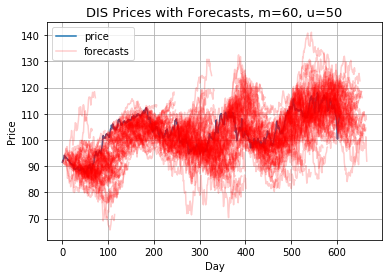

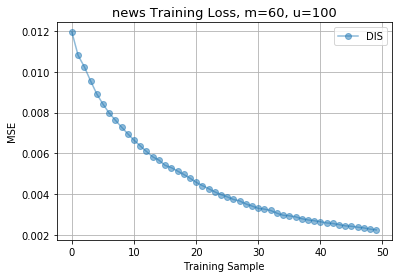



  0%|          | 0/2142 [00:00<?, ?it/s]

  0%|          | 4/2142 [00:00<01:07, 31.85it/s]

[-0.0017948   0.07031105  0.0201601  -0.03142983  0.01957527 -0.00247712
  0.02651457 -0.05440062 -0.11280446 -0.06037927 -0.05388498 -0.03446257
  0.02483461 -0.0040562  -0.04050114 -0.18512484 -0.10540491  0.07013902
  0.05433675  0.01527016 -0.05026229 -0.13827646 -0.1604097  -0.14030414
 -0.11507887 -0.16677071 -0.24280392 -0.14059743 -0.05025415 -0.11602234
 -0.09708851  0.0359866  -0.0929312  -0.11209819 -0.20052302 -0.0759854
  0.02669953 -0.00955838  0.08965648 -0.00477618 -0.25898585 -0.21905774
 -0.26548889 -0.35075377 -0.2688598  -0.34527284 -0.38857692 -0.44480395
 -0.4620578  -0.47426438 -0.60708828 -0.6327267  -0.77323846 -0.86495833
 -0.90421978 -0.89016863 -0.903238   -0.72809426 -0.80680383 -0.86698971]
news disney 50 100 60 60 trigram




  0%|          | 8/2142 [00:00<01:06, 31.85it/s]

  1%|          | 12/2142 [00:00<01:06, 32.24it/s]

  1%|          | 16/2142 [00:00<01:05, 32.68it/s]

  1%|          | 20/2142 [00:00<01:04, 32.98it/s]

  1%|          | 24/2142 [00:00<01:03, 33.46it/s]

  1%|▏         | 28/2142 [00:00<01:02, 33.78it/s]

  1%|▏         | 32/2142 [00:00<01:02, 33.79it/s]

  2%|▏         | 36/2142 [00:01<01:01, 34.07it/s]

  2%|▏         | 40/2142 [00:01<01:01, 34.42it/s]

  2%|▏         | 44/2142 [00:01<01:01, 34.24it/s]

  2%|▏         | 48/2142 [00:01<01:01, 34.00it/s]

  2%|▏         | 52/2142 [00:01<01:03, 33.15it/s]

  3%|▎         | 56/2142 [00:01<01:04, 32.47it/s]

  3%|▎         | 60/2142 [00:01<01:02, 33.10it/s]

  3%|▎         | 64/2142 [00:01<01:02, 33.07it/s]

  3%|▎         | 68/2142 [00:02<01:02, 33.43it/s]

  3%|▎         | 72/2142 [00:02<01:02, 33.21it/s]

  4%|▎         | 76/2142 [00:02<01:02, 33.25it/s]

  4%|▎         | 80/2142 [00:02<01:01, 33.52it/s]

  4%|▍         | 84/2142 [00:0

t+1 RMSE: 1.691285
t+2 RMSE: 2.252644
t+3 RMSE: 2.904795
t+4 RMSE: 3.219589
t+5 RMSE: 3.614357
t+6 RMSE: 3.898636
t+7 RMSE: 4.245093
t+8 RMSE: 4.520650
t+9 RMSE: 4.822167
t+10 RMSE: 5.087023
t+11 RMSE: 5.133907
t+12 RMSE: 5.400797
t+13 RMSE: 5.628501
t+14 RMSE: 5.886265
t+15 RMSE: 6.030051
t+16 RMSE: 6.199406
t+17 RMSE: 6.344448
t+18 RMSE: 6.684325
t+19 RMSE: 7.013059
t+20 RMSE: 7.253425
t+21 RMSE: 7.374549
t+22 RMSE: 7.504605
t+23 RMSE: 7.651056
t+24 RMSE: 7.759761
t+25 RMSE: 8.041323
t+26 RMSE: 8.215423
t+27 RMSE: 8.605051
t+28 RMSE: 8.848322
t+29 RMSE: 9.018015
t+30 RMSE: 9.255260
t+31 RMSE: 9.530300
t+32 RMSE: 9.824559
t+33 RMSE: 10.068097
t+34 RMSE: 10.202696
t+35 RMSE: 10.274747
t+36 RMSE: 10.398199
t+37 RMSE: 10.471216
t+38 RMSE: 10.577040
t+39 RMSE: 10.659571
t+40 RMSE: 10.750974
t+41 RMSE: 10.882410
t+42 RMSE: 10.762204
t+43 RMSE: 10.889476
t+44 RMSE: 10.786960
t+45 RMSE: 10.849690
t+46 RMSE: 10.920135
t+47 RMSE: 11.012400
t+48 RMSE: 11.196115
t+49 RMSE: 11.337724
t+50 RMSE: 1

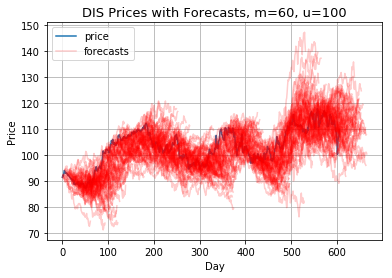

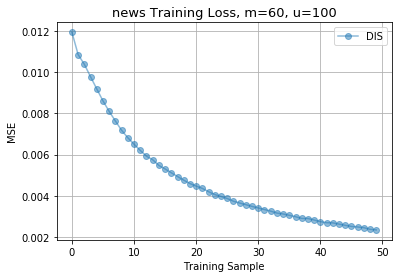

[0.20266806 0.21624696 0.43173946 0.34125575 0.47291304 0.46550994
 0.49518883 0.49756323 0.54399703 0.65859165 0.4798321  0.55663304
 0.71586952 0.78703831 0.64723869 0.50686643 0.54186303 0.82796929
 0.93030997 0.97715686 0.85301903 0.75547998 0.76464013 0.73446399
 0.83435866 0.80115877 1.04782148 1.05707036 1.0829485  1.15336463
 1.32182549 1.48876706 1.47075342 1.43892817 1.27993024 1.3874686
 1.34513946 1.34296446 1.41881833 1.45683617 1.32199132 1.14213632
 1.16548554 0.95851351 0.94662844 0.9010931  0.9982561  1.1158983
 1.2056309  1.28288413 1.12071345 1.14617759 1.1175332  1.06248802
 1.06203611 1.0750744  1.08644874 1.0884506  1.0408718  0.96127089]


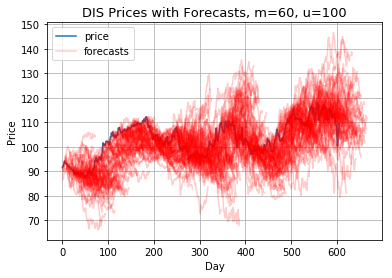

In [27]:
######################################
### LSTM News Bigrams and Trigrams ###
######################################
model_name = 'news'

# parameters
n_seq = 60
sym = 'DIS'
name = ticker2name[sym]
for n_neurons in [10, 50, 100]:
    for gramtype in ['bigram', 'trigram']:
        print(model_name, name, n_epochs, n_neurons, n_lag, n_seq, gramtype)

        # generate inputs
#         series, scaler, train, test, n_test = generate_inputs(sym, name) # arima and lstm
        series, n_test, scaler_mult, train_mult, test_mult = generate_inputs_mv(sym, name, gramtype) # lstm news

        try:
            model = load_keras_model(model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)
        except:                
            # fit model and save model and train loss
            model, train_loss = fit_lstm_mv(train_mult, n_lag, n_seq, n_batch, n_epochs, n_neurons)
            store_keras_model(model, model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)
            store_train_rmses(train_loss, model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)

        # make forecasts
        forecasts = make_forecasts_mv(model, n_batch, train_mult, test_mult, n_lag, n_seq)

        # inverse transform forecasts and test
        forecasts = inverse_transform(series, forecasts, scaler_mult, n_test)
        actual = [row[n_lag:] for row in test_mult[:,-1,:]]
        actual = inverse_transform(series, actual, scaler_mult, n_test)

        # evaluate forecasts and save test loss
        test_loss = evaluate_forecasts(actual, forecasts, n_lag, n_seq)
        store_test_rmses(test_loss, model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)

        # plot train loss and forecasts
        plot_train_loss(train_loss, sym, n_neurons, n_seq, fs)
        plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)
        
        # save plot
        plt.savefig('plots/fplots_{}_{}_{}_{}.png'.format(model_name + gramtype, name, n_seq, n_neurons))  
        
        # check
        print(np.array(test_loss) - np.array(load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)))


  0%|          | 0/2142 [00:00<?, ?it/s]

arima_news disney 50 10 60 60 onegram



  9%|▉         | 201/2142 [00:06<01:03, 30.68it/s]

Instructions for updating:
Colocations handled automatically by placer.



  0%|          | 0/50 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.



100%|██████████| 50/50 [09:16<00:00, 10.97s/it]

t+1 RMSE: 0.321091
t+2 RMSE: 0.609264
t+3 RMSE: 0.925723
t+4 RMSE: 1.235924
t+5 RMSE: 1.568153
t+6 RMSE: 1.873763
t+7 RMSE: 2.208487
t+8 RMSE: 2.517177
t+9 RMSE: 2.844492
t+10 RMSE: 3.154166
t+11 RMSE: 3.477624
t+12 RMSE: 3.785392
t+13 RMSE: 4.100620
t+14 RMSE: 4.413854
t+15 RMSE: 4.726402
t+16 RMSE: 5.037365
t+17 RMSE: 5.350812
t+18 RMSE: 5.661448
t+19 RMSE: 5.971207
t+20 RMSE: 6.281108
t+21 RMSE: 6.594138
t+22 RMSE: 6.900557
t+23 RMSE: 7.214436
t+24 RMSE: 7.521545
t+25 RMSE: 7.834806
t+26 RMSE: 8.138571
t+27 RMSE: 8.453737
t+28 RMSE: 8.757089
t+29 RMSE: 9.069202
t+30 RMSE: 9.374077
t+31 RMSE: 9.685306
t+32 RMSE: 9.991047
t+33 RMSE: 10.302165
t+34 RMSE: 10.608347
t+35 RMSE: 10.916773
t+36 RMSE: 11.223908
t+37 RMSE: 11.533055
t+38 RMSE: 11.839563
t+39 RMSE: 12.147262
t+40 RMSE: 12.453879
t+41 RMSE: 12.760779
t+42 RMSE: 13.066298
t+43 RMSE: 13.374380
t+44 RMSE: 13.678716
t+45 RMSE: 13.984766
t+46 RMSE: 14.290457
t+47 RMSE: 14.597645
t+48 RMSE: 14.902143
t+49 RMSE: 15.209339
t+50 RMSE: 1

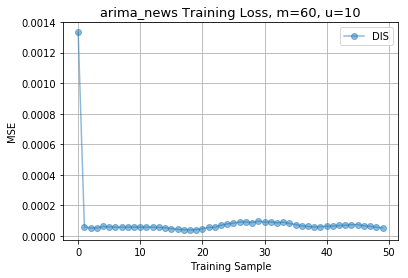


  0%|          | 0/2142 [00:00<?, ?it/s]

[-0.9313066  -1.16868159 -1.28144606 -1.34249784 -1.32205843 -1.25925069
 -1.20124923 -1.22462457 -1.13725321 -1.07635888 -0.99445234 -0.98748594
 -0.93220064 -0.81874646 -0.65329364 -0.46384111 -0.27129575 -0.3070436
 -0.23460236 -0.01410031  0.10182005  0.36555051  0.64784906  0.76630448
  0.85412642  0.94191027  1.15386247  1.42818305  1.67908244  1.92494658
  2.08529763  2.21395115  2.53960752  2.85792873  3.17539145  3.44638631
  3.58223446  3.83041063  4.08418206  4.49196526  4.76012702  5.03681624
  5.38115777  5.64860307  5.89920529  6.24778631  6.57237861  6.76164639
  7.00561863  7.27472672  7.61262206  7.96073063  8.30545388  8.58375226
  8.80190181  9.08222712  9.32610167  9.51344019  9.80839318 10.1136432 ]
arima_news disney 50 10 60 60 bigram



100%|██████████| 50/50 [09:09<00:00, 10.99s/it]

t+1 RMSE: 0.182361
t+2 RMSE: 0.308578
t+3 RMSE: 0.448081
t+4 RMSE: 0.593885
t+5 RMSE: 0.751492
t+6 RMSE: 0.914243
t+7 RMSE: 1.081427
t+8 RMSE: 1.251355
t+9 RMSE: 1.417801
t+10 RMSE: 1.591758
t+11 RMSE: 1.767786
t+12 RMSE: 1.938756
t+13 RMSE: 2.118451
t+14 RMSE: 2.286620
t+15 RMSE: 2.470319
t+16 RMSE: 2.637322
t+17 RMSE: 2.821609
t+18 RMSE: 2.992173
t+19 RMSE: 3.174142
t+20 RMSE: 3.347125
t+21 RMSE: 3.528422
t+22 RMSE: 3.702704
t+23 RMSE: 3.881527
t+24 RMSE: 4.057217
t+25 RMSE: 4.234013
t+26 RMSE: 4.409027
t+27 RMSE: 4.588004
t+28 RMSE: 4.764964
t+29 RMSE: 4.945971
t+30 RMSE: 5.123190
t+31 RMSE: 5.302148
t+32 RMSE: 5.475789
t+33 RMSE: 5.656836
t+34 RMSE: 5.830514
t+35 RMSE: 6.010251
t+36 RMSE: 6.185569
t+37 RMSE: 6.366973
t+38 RMSE: 6.540618
t+39 RMSE: 6.720487
t+40 RMSE: 6.895502
t+41 RMSE: 7.073229
t+42 RMSE: 7.249143
t+43 RMSE: 7.427228
t+44 RMSE: 7.603532
t+45 RMSE: 7.782370
t+46 RMSE: 7.958533
t+47 RMSE: 8.136314
t+48 RMSE: 8.310937
t+49 RMSE: 8.490259
t+50 RMSE: 8.666031
t+51 RMSE

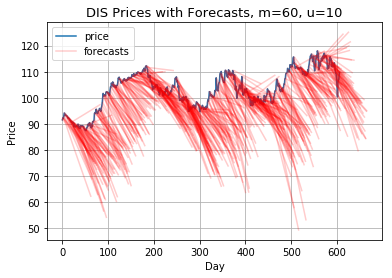

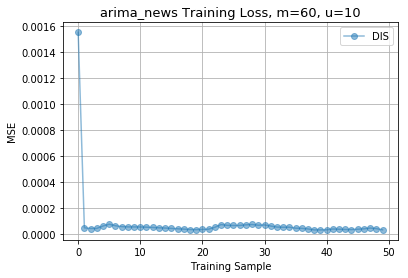


  0%|          | 0/2142 [00:00<?, ?it/s]

[-1.07003645 -1.46936763 -1.75908808 -1.9845374  -2.13871954 -2.21877102
 -2.32830884 -2.49044674 -2.56394435 -2.63876719 -2.70429051 -2.83412196
 -2.91437049 -2.94597991 -2.90937624 -2.86388344 -2.8004985  -2.976318
 -3.03166809 -2.94808328 -2.96389578 -2.83230204 -2.68505969 -2.69802406
 -2.74666593 -2.78763364 -2.71187046 -2.56394132 -2.4441486  -2.32594048
 -2.29786099 -2.30130771 -2.105722   -1.91990422 -1.73113015 -1.59195303
 -1.58384725 -1.46853457 -1.34259314 -1.06641157 -0.92742235 -0.78033884
 -0.56599448 -0.42658093 -0.30319084 -0.08413825  0.11104786  0.1704401
  0.28653877  0.42642716  0.63773197  0.85774665  1.07770624  1.22652674
  1.31818919  1.47037851  1.58842639  1.64635303  1.81620998  1.99434786]
arima_news disney 50 10 60 60 trigram



100%|██████████| 50/50 [09:13<00:00, 10.98s/it]

t+1 RMSE: 0.271527
t+2 RMSE: 0.441253
t+3 RMSE: 0.601285
t+4 RMSE: 0.758074
t+5 RMSE: 0.912943
t+6 RMSE: 1.063315
t+7 RMSE: 1.215099
t+8 RMSE: 1.366897
t+9 RMSE: 1.516345
t+10 RMSE: 1.665662
t+11 RMSE: 1.814872
t+12 RMSE: 1.962160
t+13 RMSE: 2.113108
t+14 RMSE: 2.262156
t+15 RMSE: 2.414065
t+16 RMSE: 2.560721
t+17 RMSE: 2.713197
t+18 RMSE: 2.861777
t+19 RMSE: 3.012905
t+20 RMSE: 3.162582
t+21 RMSE: 3.314393
t+22 RMSE: 3.464222
t+23 RMSE: 3.614247
t+24 RMSE: 3.765177
t+25 RMSE: 3.915127
t+26 RMSE: 4.066285
t+27 RMSE: 4.216690
t+28 RMSE: 4.367738
t+29 RMSE: 4.519266
t+30 RMSE: 4.670114
t+31 RMSE: 4.822642
t+32 RMSE: 4.973488
t+33 RMSE: 5.125712
t+34 RMSE: 5.277490
t+35 RMSE: 5.429026
t+36 RMSE: 5.579750
t+37 RMSE: 5.731836
t+38 RMSE: 5.882656
t+39 RMSE: 6.035256
t+40 RMSE: 6.187349
t+41 RMSE: 6.339156
t+42 RMSE: 6.491009
t+43 RMSE: 6.642860
t+44 RMSE: 6.794270
t+45 RMSE: 6.946171
t+46 RMSE: 7.098309
t+47 RMSE: 7.249522
t+48 RMSE: 7.401313
t+49 RMSE: 7.552611
t+50 RMSE: 7.704554
t+51 RMSE

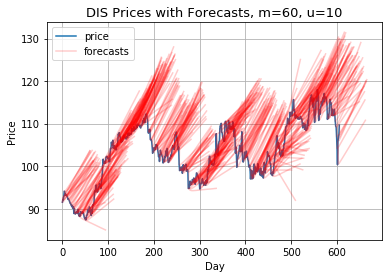

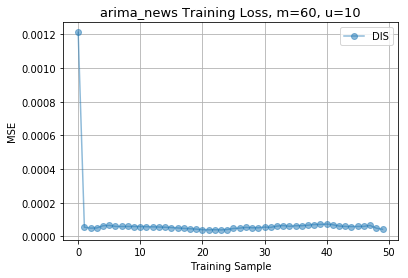


  0%|          | 0/2142 [00:00<?, ?it/s]

[-0.98087036 -1.33669173 -1.60588411 -1.82034784 -1.97726874 -2.0696988
 -2.1946371  -2.37490459 -2.46540039 -2.56486345 -2.65720472 -2.81071761
 -2.91971271 -2.9704442  -2.96563044 -2.94048479 -2.90891056 -3.10671477
 -3.19290484 -3.13262548 -3.17792485 -3.07078444 -2.95233942 -2.99006396
 -3.06555186 -3.13037579 -3.08318509 -2.96116752 -2.87085314 -2.77901667
 -2.77736707 -2.80360858 -2.636846   -2.47292864 -2.31235535 -2.19777197
 -2.21898445 -2.12649633 -2.0278239  -1.77456437 -1.66149575 -1.53847307
 -1.35036254 -1.23584288 -1.13938993 -0.94436199 -0.7757441  -0.7391837
 -0.65110891 -0.53504934 -0.35048724 -0.15521776  0.0362859   0.16109112
  0.22665089  0.35367786  0.44537874  0.48041767  0.62159658  0.77492526]
arima_news disney 50 50 60 60 onegram



100%|██████████| 50/50 [09:12<00:00, 11.01s/it]

t+1 RMSE: 0.180547
t+2 RMSE: 0.284539
t+3 RMSE: 0.388924
t+4 RMSE: 0.483544
t+5 RMSE: 0.590890
t+6 RMSE: 0.690012
t+7 RMSE: 0.796755
t+8 RMSE: 0.898577
t+9 RMSE: 1.006824
t+10 RMSE: 1.109703
t+11 RMSE: 1.218854
t+12 RMSE: 1.329604
t+13 RMSE: 1.438497
t+14 RMSE: 1.548190
t+15 RMSE: 1.658942
t+16 RMSE: 1.772587
t+17 RMSE: 1.882957
t+18 RMSE: 1.996888
t+19 RMSE: 2.111156
t+20 RMSE: 2.223083
t+21 RMSE: 2.336680
t+22 RMSE: 2.450602
t+23 RMSE: 2.565271
t+24 RMSE: 2.678321
t+25 RMSE: 2.792776
t+26 RMSE: 2.905290
t+27 RMSE: 3.018363
t+28 RMSE: 3.134413
t+29 RMSE: 3.247506
t+30 RMSE: 3.361382
t+31 RMSE: 3.478191
t+32 RMSE: 3.592215
t+33 RMSE: 3.706065
t+34 RMSE: 3.821450
t+35 RMSE: 3.935759
t+36 RMSE: 4.050768
t+37 RMSE: 4.165122
t+38 RMSE: 4.281092
t+39 RMSE: 4.395511
t+40 RMSE: 4.510781
t+41 RMSE: 4.626093
t+42 RMSE: 4.743672
t+43 RMSE: 4.859015
t+44 RMSE: 4.973974
t+45 RMSE: 5.088298
t+46 RMSE: 5.202636
t+47 RMSE: 5.318584
t+48 RMSE: 5.432633
t+49 RMSE: 5.547805
t+50 RMSE: 5.663072
t+51 RMSE

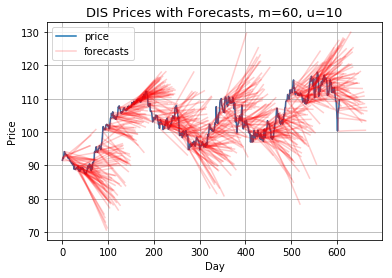

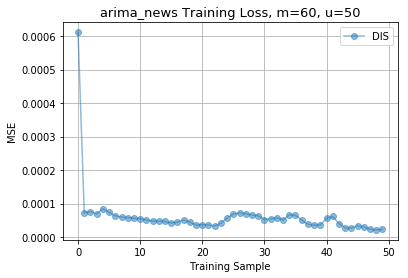


  0%|          | 0/2142 [00:00<?, ?it/s]

[-1.22699787 -1.66858441 -2.03933204 -2.18181793 -2.39112069 -2.39739756
 -2.55647352 -2.5968422  -2.71627839 -2.81312896 -2.90269684 -2.82138429
 -2.94590404 -3.00561707 -3.15141995 -3.10629521 -3.08884322 -3.17393614
 -3.25616659 -3.3276418  -3.37453016 -3.52157189 -3.43501386 -3.54678129
 -3.71726057 -3.73468643 -3.75412118 -3.76112918 -3.87878672 -3.97345471
 -4.07213407 -4.25698438 -4.25484881 -4.35058672 -4.36856724 -4.38890875
 -4.55441206 -4.56614412 -4.55018151 -4.49302259 -4.50875128 -4.3660135
 -4.31506603 -4.28090262 -4.29173623 -4.29165881 -4.20114992 -4.15445284
 -3.97248766 -3.93599156 -3.8754874  -3.68833386 -3.56134082 -3.47933882
 -3.39715409 -3.28698016 -3.19814459 -3.18992589 -3.00533508 -2.77532059]
arima_news disney 50 50 60 60 bigram



100%|██████████| 50/50 [09:11<00:00, 10.99s/it]

t+1 RMSE: 0.196066
t+2 RMSE: 0.297572
t+3 RMSE: 0.405389
t+4 RMSE: 0.499300
t+5 RMSE: 0.609245
t+6 RMSE: 0.706844
t+7 RMSE: 0.817096
t+8 RMSE: 0.919775
t+9 RMSE: 1.030097
t+10 RMSE: 1.136576
t+11 RMSE: 1.245676
t+12 RMSE: 1.352956
t+13 RMSE: 1.463438
t+14 RMSE: 1.576548
t+15 RMSE: 1.687689
t+16 RMSE: 1.799966
t+17 RMSE: 1.913824
t+18 RMSE: 2.028080
t+19 RMSE: 2.144062
t+20 RMSE: 2.255937
t+21 RMSE: 2.371979
t+22 RMSE: 2.485033
t+23 RMSE: 2.602953
t+24 RMSE: 2.717580
t+25 RMSE: 2.836126
t+26 RMSE: 2.950346
t+27 RMSE: 3.069161
t+28 RMSE: 3.184768
t+29 RMSE: 3.302597
t+30 RMSE: 3.420303
t+31 RMSE: 3.537492
t+32 RMSE: 3.653271
t+33 RMSE: 3.772493
t+34 RMSE: 3.889799
t+35 RMSE: 4.007784
t+36 RMSE: 4.126256
t+37 RMSE: 4.245521
t+38 RMSE: 4.362004
t+39 RMSE: 4.480076
t+40 RMSE: 4.599726
t+41 RMSE: 4.718623
t+42 RMSE: 4.835913
t+43 RMSE: 4.955090
t+44 RMSE: 5.072222
t+45 RMSE: 5.190877
t+46 RMSE: 5.308513
t+47 RMSE: 5.427186
t+48 RMSE: 5.544876
t+49 RMSE: 5.662054
t+50 RMSE: 5.781120
t+51 RMSE

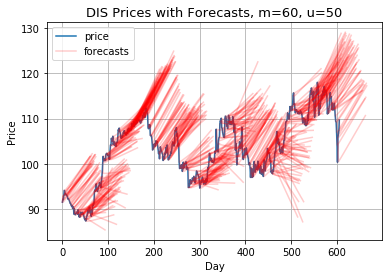

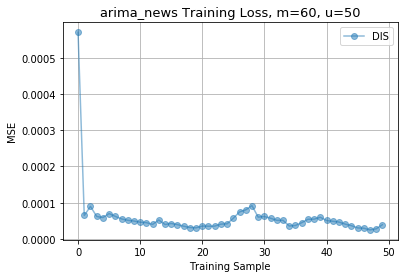


  0%|          | 3/2142 [00:00<01:14, 28.74it/s]

[-1.21147866 -1.65555162 -2.02286742 -2.16606131 -2.37276573 -2.38056568
 -2.53613336 -2.57564412 -2.6930054  -2.78625586 -2.87587469 -2.7980324
 -2.92096227 -2.97725885 -3.12267269 -3.07891567 -3.05797643 -3.14274448
 -3.22326085 -3.29478838 -3.33923037 -3.48714045 -3.39733241 -3.50752219
 -3.67391064 -3.68962988 -3.70332385 -3.71077513 -3.8236957  -3.91453391
 -4.01283303 -4.19592826 -4.18842065 -4.28223743 -4.29654229 -4.3134207
 -4.47401221 -4.48523259 -4.46561584 -4.40407814 -4.41622136 -4.27377228
 -4.21899091 -4.18265406 -4.18915652 -4.18578265 -4.09254857 -4.04221046
 -3.85823896 -3.81794306 -3.75400032 -3.56161259 -3.43258941 -3.34647554
 -3.26115821 -3.14909053 -3.05525373 -3.04525362 -2.85538838 -2.62156469]
arima_news disney 50 50 60 60 trigram



100%|██████████| 50/50 [09:11<00:00, 11.00s/it]

t+1 RMSE: 0.217024
t+2 RMSE: 0.340841
t+3 RMSE: 0.468984
t+4 RMSE: 0.587271
t+5 RMSE: 0.714968
t+6 RMSE: 0.834675
t+7 RMSE: 0.959069
t+8 RMSE: 1.084128
t+9 RMSE: 1.208910
t+10 RMSE: 1.338344
t+11 RMSE: 1.465706
t+12 RMSE: 1.596112
t+13 RMSE: 1.725964
t+14 RMSE: 1.858857
t+15 RMSE: 1.991709
t+16 RMSE: 2.125003
t+17 RMSE: 2.261583
t+18 RMSE: 2.395532
t+19 RMSE: 2.534169
t+20 RMSE: 2.669635
t+21 RMSE: 2.809591
t+22 RMSE: 2.946107
t+23 RMSE: 3.086116
t+24 RMSE: 3.225070
t+25 RMSE: 3.364549
t+26 RMSE: 3.505234
t+27 RMSE: 3.645464
t+28 RMSE: 3.786924
t+29 RMSE: 3.928270
t+30 RMSE: 4.070477
t+31 RMSE: 4.210999
t+32 RMSE: 4.353704
t+33 RMSE: 4.495859
t+34 RMSE: 4.638634
t+35 RMSE: 4.781783
t+36 RMSE: 4.923712
t+37 RMSE: 5.067322
t+38 RMSE: 5.209689
t+39 RMSE: 5.353494
t+40 RMSE: 5.496601
t+41 RMSE: 5.640568
t+42 RMSE: 5.783450
t+43 RMSE: 5.927065
t+44 RMSE: 6.071217
t+45 RMSE: 6.215403
t+46 RMSE: 6.359743
t+47 RMSE: 6.503572
t+48 RMSE: 6.648221
t+49 RMSE: 6.792189
t+50 RMSE: 6.936492
t+51 RMSE

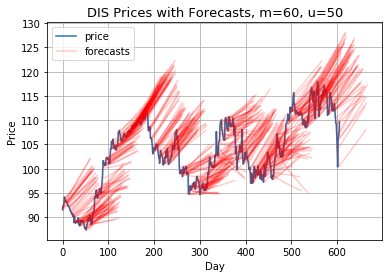

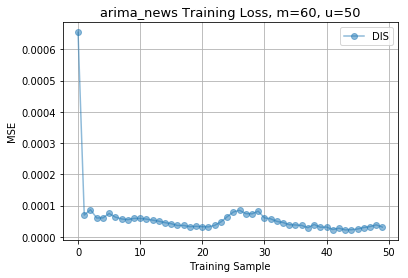


  0%|          | 0/2142 [00:00<?, ?it/s]

[-1.19052102 -1.61228232 -1.95927239 -2.07809054 -2.26704234 -2.25273467
 -2.39416033 -2.41129113 -2.51419278 -2.58448851 -2.65584494 -2.55487634
 -2.65843655 -2.69494993 -2.81865242 -2.7538785  -2.71021704 -2.77529223
 -2.83315377 -2.88109054 -2.9016193  -3.02606718 -2.91416897 -3.00003156
 -3.14548755 -3.13474251 -3.12702086 -3.10861831 -3.19802224 -3.2643605
 -3.33932571 -3.49549558 -3.46505407 -3.53340246 -3.5225427  -3.51596492
 -3.65221118 -3.63754735 -3.59219848 -3.50720263 -3.49427682 -3.32623559
 -3.24701574 -3.18365932 -3.16463127 -3.13455239 -3.01616262 -2.93886493
 -2.72810449 -2.66257155 -2.57308413 -2.35551523 -2.20064846 -2.08921405
 -1.97854914 -1.84000963 -1.7197548  -1.68273743 -1.46705064 -1.20776619]
arima_news disney 50 100 60 60 onegram



100%|██████████| 50/50 [09:43<00:00, 11.68s/it]

t+1 RMSE: 0.215560
t+2 RMSE: 0.341762
t+3 RMSE: 0.476929
t+4 RMSE: 0.594553
t+5 RMSE: 0.730596
t+6 RMSE: 0.852868
t+7 RMSE: 0.987416
t+8 RMSE: 1.115052
t+9 RMSE: 1.253086
t+10 RMSE: 1.381872
t+11 RMSE: 1.520455
t+12 RMSE: 1.653144
t+13 RMSE: 1.792223
t+14 RMSE: 1.927190
t+15 RMSE: 2.068490
t+16 RMSE: 2.205788
t+17 RMSE: 2.348000
t+18 RMSE: 2.485527
t+19 RMSE: 2.630827
t+20 RMSE: 2.768246
t+21 RMSE: 2.912989
t+22 RMSE: 3.053811
t+23 RMSE: 3.198303
t+24 RMSE: 3.338577
t+25 RMSE: 3.484042
t+26 RMSE: 3.625254
t+27 RMSE: 3.771065
t+28 RMSE: 3.912872
t+29 RMSE: 4.057494
t+30 RMSE: 4.197868
t+31 RMSE: 4.343263
t+32 RMSE: 4.486104
t+33 RMSE: 4.631636
t+34 RMSE: 4.774777
t+35 RMSE: 4.920484
t+36 RMSE: 5.062990
t+37 RMSE: 5.209374
t+38 RMSE: 5.351755
t+39 RMSE: 5.497848
t+40 RMSE: 5.640973
t+41 RMSE: 5.787569
t+42 RMSE: 5.931666
t+43 RMSE: 6.077343
t+44 RMSE: 6.219840
t+45 RMSE: 6.365957
t+46 RMSE: 6.507818
t+47 RMSE: 6.654747
t+48 RMSE: 6.797688
t+49 RMSE: 6.943499
t+50 RMSE: 7.088007
t+51 RMSE

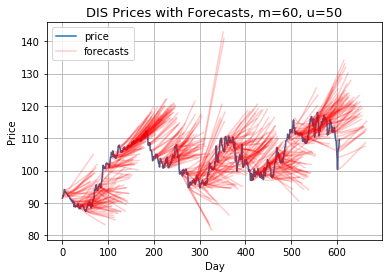

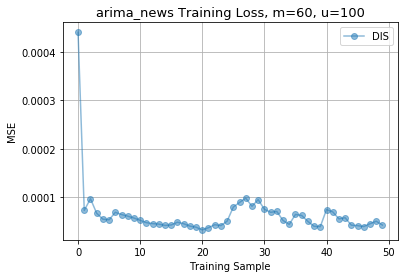


  0%|          | 0/2142 [00:00<?, ?it/s]

[-1.27305679 -1.69463452 -1.99612674 -2.28378063 -2.41084847 -2.58025851
 -2.76248886 -2.9080348  -3.02508386 -3.04655942 -3.13362004 -3.19102027
 -3.12040893 -3.17203623 -3.31432249 -3.48675193 -3.45458509 -3.3708279
 -3.4519222  -3.50802268 -3.60854083 -3.69531347 -3.68811323 -3.68672042
 -3.72292234 -3.7890103  -3.78616512 -3.87837969 -3.87757292 -3.90402714
 -3.86521101 -3.84968787 -3.9657075  -3.98899042 -4.07433316 -3.94774013
 -3.91670229 -3.8823211  -3.74290387 -3.65316459 -3.77284919 -3.68840192
 -3.64664709 -3.60860666 -3.53710453 -3.51122426 -3.35939661 -3.28252878
 -3.18859416 -3.08295976 -3.02945441 -2.96857694 -2.93627015 -2.86971634
 -2.88928012 -2.83453276 -2.74076032 -2.60100982 -2.55165523 -2.45973367]
arima_news disney 50 100 60 60 bigram



100%|██████████| 50/50 [09:42<00:00, 11.64s/it]

t+1 RMSE: 0.183018
t+2 RMSE: 0.295667
t+3 RMSE: 0.399717
t+4 RMSE: 0.497516
t+5 RMSE: 0.600544
t+6 RMSE: 0.699773
t+7 RMSE: 0.801102
t+8 RMSE: 0.901681
t+9 RMSE: 1.003338
t+10 RMSE: 1.106157
t+11 RMSE: 1.206751
t+12 RMSE: 1.313228
t+13 RMSE: 1.416013
t+14 RMSE: 1.522361
t+15 RMSE: 1.626405
t+16 RMSE: 1.735171
t+17 RMSE: 1.839516
t+18 RMSE: 1.948328
t+19 RMSE: 2.056603
t+20 RMSE: 2.163766
t+21 RMSE: 2.273131
t+22 RMSE: 2.381964
t+23 RMSE: 2.491126
t+24 RMSE: 2.599772
t+25 RMSE: 2.710475
t+26 RMSE: 2.820179
t+27 RMSE: 2.930350
t+28 RMSE: 3.041159
t+29 RMSE: 3.151534
t+30 RMSE: 3.262388
t+31 RMSE: 3.373207
t+32 RMSE: 3.485017
t+33 RMSE: 3.593464
t+34 RMSE: 3.704715
t+35 RMSE: 3.815426
t+36 RMSE: 3.926082
t+37 RMSE: 4.037105
t+38 RMSE: 4.148253
t+39 RMSE: 4.259509
t+40 RMSE: 4.369964
t+41 RMSE: 4.482332
t+42 RMSE: 4.592637
t+43 RMSE: 4.703748
t+44 RMSE: 4.815406
t+45 RMSE: 4.927363
t+46 RMSE: 5.038526
t+47 RMSE: 5.150817
t+48 RMSE: 5.262186
t+49 RMSE: 5.373612
t+50 RMSE: 5.485047
t+51 RMSE

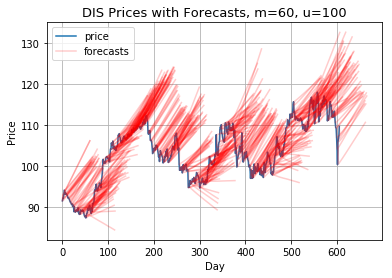

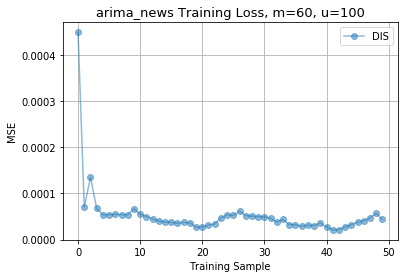


  0%|          | 0/2142 [00:00<?, ?it/s]

[-1.30559937 -1.7407303  -2.07333922 -2.38081736 -2.54089981 -2.73335362
 -2.94880304 -3.12140661 -3.27483257 -3.32227476 -3.4473238  -3.530936
 -3.49661853 -3.57686579 -3.75640752 -3.95736887 -3.96306867 -3.90802767
 -4.02614654 -4.11250239 -4.24839892 -4.36716114 -4.39528989 -4.4255252
 -4.49648896 -4.59408605 -4.62688014 -4.75009227 -4.78353304 -4.83950702
 -4.83526693 -4.85077492 -5.00387905 -5.0590525  -5.17939069 -5.08464794
 -5.08897154 -5.08582283 -4.98124296 -4.92417377 -5.07808631 -5.02743095
 -5.02024253 -5.01304066 -4.97569885 -4.98051618 -4.86332701 -4.81803007
 -4.75848144 -4.68592011 -4.66810468 -4.63820772 -4.64064614 -4.60635841
 -4.66050633 -4.63939476 -4.58092392 -4.47383969 -4.45765677 -4.39889872]
arima_news disney 50 100 60 60 trigram



100%|██████████| 50/50 [09:44<00:00, 11.71s/it]

t+1 RMSE: 0.216678
t+2 RMSE: 0.328556
t+3 RMSE: 0.427100
t+4 RMSE: 0.530737
t+5 RMSE: 0.627425
t+6 RMSE: 0.730830
t+7 RMSE: 0.828621
t+8 RMSE: 0.931111
t+9 RMSE: 1.030225
t+10 RMSE: 1.131076
t+11 RMSE: 1.232460
t+12 RMSE: 1.332069
t+13 RMSE: 1.434983
t+14 RMSE: 1.535003
t+15 RMSE: 1.638862
t+16 RMSE: 1.739696
t+17 RMSE: 1.843345
t+18 RMSE: 1.945201
t+19 RMSE: 2.048997
t+20 RMSE: 2.152759
t+21 RMSE: 2.256340
t+22 RMSE: 2.360653
t+23 RMSE: 2.464015
t+24 RMSE: 2.569096
t+25 RMSE: 2.672249
t+26 RMSE: 2.777620
t+27 RMSE: 2.882003
t+28 RMSE: 2.986984
t+29 RMSE: 3.091672
t+30 RMSE: 3.196588
t+31 RMSE: 3.301655
t+32 RMSE: 3.406121
t+33 RMSE: 3.511473
t+34 RMSE: 3.616181
t+35 RMSE: 3.721757
t+36 RMSE: 3.826901
t+37 RMSE: 3.932102
t+38 RMSE: 4.037321
t+39 RMSE: 4.143306
t+40 RMSE: 4.248681
t+41 RMSE: 4.353905
t+42 RMSE: 4.459514
t+43 RMSE: 4.564954
t+44 RMSE: 4.670438
t+45 RMSE: 4.775657
t+46 RMSE: 4.881144
t+47 RMSE: 4.986754
t+48 RMSE: 5.092607
t+49 RMSE: 5.198455
t+50 RMSE: 5.303942
t+51 RMSE

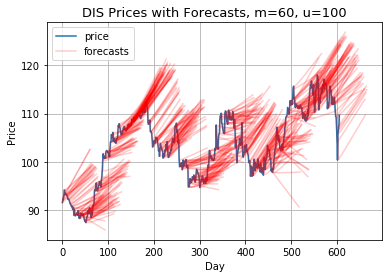

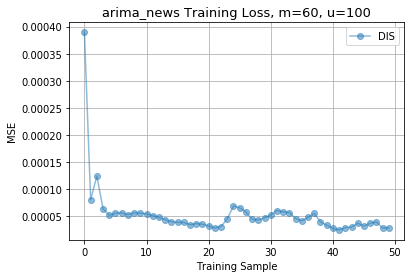

[-1.27193863 -1.70784112 -2.04595564 -2.34759593 -2.51401946 -2.70229637
 -2.92128385 -3.09197575 -3.247945   -3.29735496 -3.42161486 -3.5120947
 -3.47764923 -3.56422302 -3.74394991 -3.95284403 -3.9592395  -3.91115472
 -4.03375245 -4.12350914 -4.26519011 -4.388472   -4.42240057 -4.45620146
 -4.53471519 -4.6366442  -4.6752263  -4.80426771 -4.84339483 -4.90530696
 -4.90681878 -4.9296704  -5.08586995 -5.14758716 -5.27306015 -5.18382913
 -5.19397429 -5.19675525 -5.09744679 -5.04545629 -5.20651329 -5.16055357
 -5.15903685 -5.15800873 -5.12740391 -5.13789857 -5.02738916 -4.98760998
 -4.93363833 -4.86702524 -4.85531244 -4.83171369 -4.8406244  -4.81124955
 -4.87124655 -4.85513544 -4.80281423 -4.70037429 -4.69084624 -4.63781348]


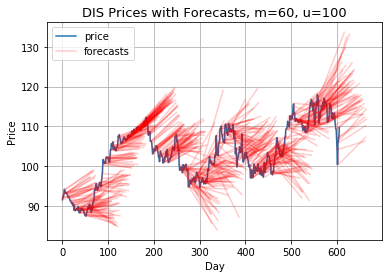

In [24]:
#######################
### LSTM ARIMA News ###
#######################
model_name = 'arima_news'
gramtype = 'onegram'

# parameters
n_seq = 60
sym = 'DIS'
name = ticker2name[sym]
for n_neurons in [10, 50, 100]:
    for gramtype in ['onegram', 'bigram', 'trigram']:
        print(model_name, name, n_epochs, n_neurons, n_lag, n_seq, gramtype)

        # generate inputs
        series, scaler, train, test, n_test = generate_inputs(sym, name) # arima and lstm
        series, n_test, scaler_mult, train_mult, test_mult = generate_inputs_mv(sym, name, gramtype) # lstm news

        # ARIMA boost data from fitted and forecasts
        try:
            arima_train_data, arima_test_data = load_arima_boost_data('boost', name, n_epochs, 0, n_lag, n_seq)
        except:
            arima_train_data = arima_boost_data(train, n_lag, n_seq)
            arima_test_data = arima_boost_data(test, n_lag, n_seq)
            store_arima_boost_data((arima_train_data, arima_test_data), 'boost', name, n_epochs, 0, n_lag, n_seq)
            
        # ARIMA enriched data sets
        arima_train_data = np.array(arima_train_data).reshape(len(arima_train_data), 1, len(arima_train_data[0]))
        arima_test_data = np.array(arima_test_data).reshape(len(arima_test_data), 1, len(arima_test_data[0]))
        train_mult = np.concatenate((train_mult, arima_train_data), axis=1)
        test_mult = np.concatenate((test_mult, arima_test_data), axis=1)

        # fit model and save model and train loss
        model, train_loss = fit_lstm_mv(train_mult, n_lag, n_seq, n_batch, n_epochs, n_neurons)
        store_keras_model(model, model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)
        store_train_rmses(train_loss, model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)

        # make forecasts
        forecasts = make_forecasts_mv(model, n_batch, train_mult, test_mult, n_lag, n_seq)

        # inverse transform forecasts and test
        forecasts = inverse_transform(series, forecasts, scaler_mult, n_test)
        actual = [row[n_lag:] for row in test_mult[:,-1,:]]
        actual = inverse_transform(series, actual, scaler_mult, n_test)

        # evaluate forecasts and save test loss
        test_loss = evaluate_forecasts(actual, forecasts, n_lag, n_seq)
        store_test_rmses(test_loss, model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)

        # plot train loss and forecasts
        plot_train_loss(train_loss, sym, n_neurons, n_seq, fs)
        plot_forecasts(series, forecasts, n_test, sym, n_neurons, n_seq, fs)
        
        # save plot
        plt.savefig('plots/fplots_{}_{}_{}_{}.png'.format(model_name + gramtype, name, n_seq, n_neurons))  
        
        # check
        print(np.array(test_loss) - np.array(load_test_rmses('news', name, n_epochs, n_neurons, n_lag, n_seq)))

<Figure size 432x288 with 0 Axes>

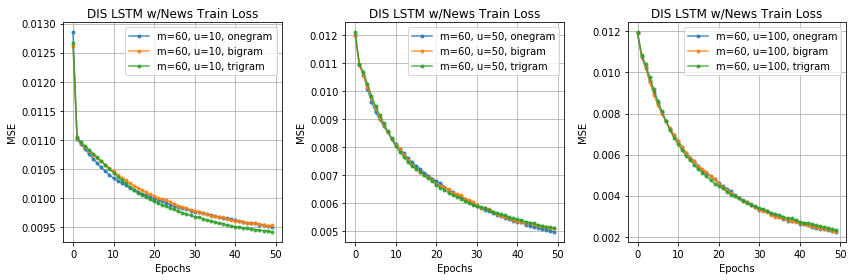

In [19]:
# plot train losses for disney over grams
model_name = 'news'
n_seq = 60
n_neuronss = [10, 50, 100]
plt.figure()
f, axarr = plt.subplots(1, 3, figsize=(12,4))
sym = 'DIS'
name = ticker2name[sym]
gramtypes = ['', 'bigram', 'trigram']
gramtypes_plotting = ['onegram', 'bigram', 'trigram']
for i in range(len(gramtypes)):
    gramtype = gramtypes[i]
    for j in range(len(n_neuronss)):
        n_neurons = n_neuronss[j]
        loaded_rmses = load_train_rmses(model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)
        axarr[j].set_title('{} LSTM w/News Train Loss'.format(sym))#, fontsize=16)
        axarr[j].set_xlabel('Epochs')#, fontsize=13)
        axarr[j].set_ylabel('MSE')#, fontsize=13)
        axarr[j].plot(loaded_rmses, '.-', label='m={}, u={}, {}'.format(n_seq, n_neurons, gramtypes_plotting[i]), alpha=.8)
        axarr[j].legend()
        axarr[j].grid()
plt.tight_layout()
plt.savefig('plots/trainloss_onebitri.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

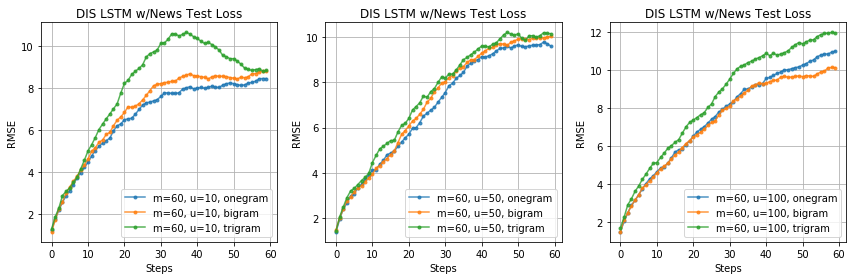

In [18]:
# plot test losses for disney over grams
model_name = 'news'
n_seq = 60
n_neuronss = [10, 50, 100]
plt.figure()
f, axarr = plt.subplots(1, 3, figsize=(12,4))
sym = 'DIS'
name = ticker2name[sym]
gramtypes = ['', 'bigram', 'trigram']
gramtypes_plotting = ['onegram', 'bigram', 'trigram']
for i in range(len(gramtypes)):
    gramtype = gramtypes[i]
    for j in range(len(n_neuronss)):
        n_neurons = n_neuronss[j]
        loaded_rmses = load_test_rmses(model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)
        axarr[j].set_title('{} LSTM w/News Test Loss'.format(sym))#, fontsize=16)
        axarr[j].set_xlabel('Steps')#, fontsize=13)
        axarr[j].set_ylabel('RMSE')#, fontsize=13)
        axarr[j].plot(loaded_rmses, '.-', label='m={}, u={}, {}'.format(n_seq, n_neurons, gramtypes_plotting[i]), alpha=.8)
        axarr[j].legend()
        axarr[j].grid()
plt.tight_layout()
plt.savefig('plots/testloss_onebitri.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

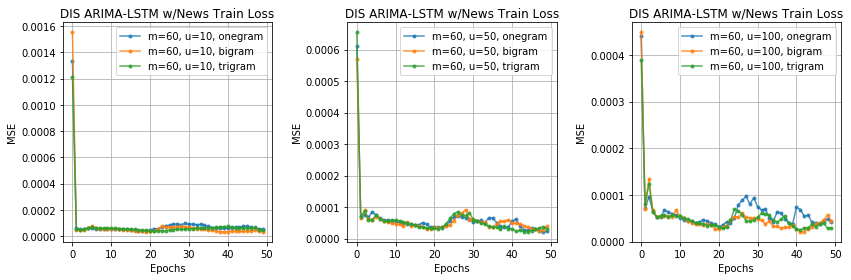

In [17]:
# plot train losses for disney with arima-enrichment
model_name = 'arima_news'
n_seq = 60
n_neuronss = [10, 50, 100]
plt.figure()
f, axarr = plt.subplots(1, 3, figsize=(12,4))
sym = 'DIS'
name = ticker2name[sym]
gramtypes = ['onegram', 'bigram', 'trigram']
for i in range(len(gramtypes)):
    gramtype = gramtypes[i]
    for j in range(len(n_neuronss)):
        n_neurons = n_neuronss[j]
        loaded_rmses = load_train_rmses(model_name + gramtype, name, n_epochs, n_neurons, n_lag, n_seq)
        axarr[j].set_title('{} ARIMA-LSTM w/News Train Loss'.format(sym))#, fontsize=16)
        axarr[j].set_xlabel('Epochs')#, fontsize=13)
        axarr[j].set_ylabel('MSE')#, fontsize=13)
        axarr[j].plot(loaded_rmses, '.-', label='m={}, u={}, {}'.format(n_seq, n_neurons, gramtype), alpha=.8)
        axarr[j].legend()
        axarr[j].grid()
plt.tight_layout()
plt.savefig('plots/trainloss_DISNEY.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

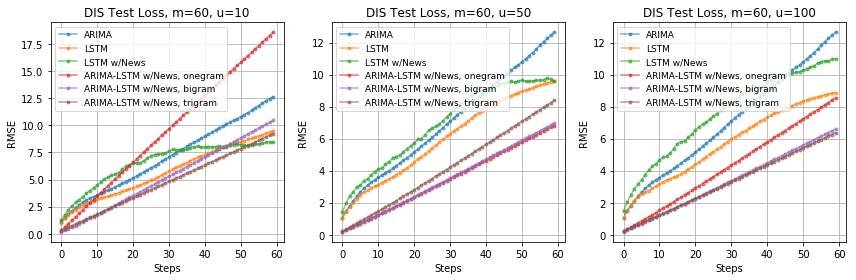

In [16]:
# compare loss between disney models
model = 'arima_news'
gramtype = 'trigram'
n_seq = 60
n_neuronss = [10, 50, 100]
sym = 'DIS'
name = ticker2name[sym] 
plt.figure()
f, axarr = plt.subplots(1, 3, figsize=(12,4))
for j in range(len(n_neuronss)):
    n_neurons = n_neuronss[j]

    # load losses
    model_name = 'arima'
    test_loss_arima = load_test_rmses(model_name, name, n_epochs, 0, n_lag, n_seq)
    model_name = 'lstm'
    test_loss_lstm = load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
    model_name = 'news'
    test_loss_news = load_test_rmses(model_name, name, n_epochs, n_neurons, n_lag, n_seq)
    model_name = 'arima_news'
    test_loss_arima_news_onegram = load_test_rmses(model_name + 'onegram', name, n_epochs, n_neurons, n_lag, n_seq)
    model_name = 'arima_news'
    test_loss_arima_news_bigram = load_test_rmses(model_name + 'bigram', name, n_epochs, n_neurons, n_lag, n_seq)
    model_name = 'arima_news'
    test_loss_arima_news_trigram = load_test_rmses(model_name + 'trigram', name, n_epochs, n_neurons, n_lag, n_seq)
    
#     # table of rmses
#     for i in range(n_seq):
#         string = '{} & {} & {} & {} & {} & {} & {} \\\\'.format(i+1, np.round(test_loss_arima[i],3), 
#                                                                      np.round(test_loss_lstm[i],3),
#                                                                      np.round(test_loss_news[i], 3), 
#                                                                      np.round(test_loss_arima_news_onegram[i], 3),
#                                                                      np.round(test_loss_arima_news_bigram[i], 3), 
#                                                                      np.round(test_loss_arima_news_trigram[i], 3))
#         print(string)
#     print('\n')
    
    # plot
    axarr[j].set_title('{} Test Loss, m={}, u={}'.format(sym, n_seq, n_neurons))#, fontsize=16)
    axarr[j].set_xlabel('Steps')#, fontsize=13)
    axarr[j].set_ylabel('RMSE')#, fontsize=13)
    axarr[j].plot(test_loss_arima, '.-', alpha=.6, label='ARIMA')
    axarr[j].plot(test_loss_lstm, '.-', alpha=.6, label='LSTM')
    axarr[j].plot(test_loss_news, '.-', alpha=.6, label='LSTM w/News')
    axarr[j].plot(test_loss_arima_news_onegram, '.-', alpha=.6, label='ARIMA-LSTM w/News, onegram')
    axarr[j].plot(test_loss_arima_news_bigram, '.-', alpha=.6, label='ARIMA-LSTM w/News, bigram')
    axarr[j].plot(test_loss_arima_news_trigram, '.-', alpha=.6, label='ARIMA-LSTM w/News, trigram')
    axarr[j].legend(fontsize=9)
    axarr[j].grid()
plt.tight_layout()
plt.savefig('plots/testloss_DISNEY.png'.format('all', name, 'comparison'), bbox_inches='tight')   